# Lamprey Transcriptome Analysis: Transcript Analysis Notebook

```
Camille Scott [camille dot scott dot w @gmail.com] [@camille_codon]

camillescott.github.io

Lab for Data Intensive Biology (DIB)
University of California Davis
```

## About

This explores basic metrics on the assembled transcripts; counts, lengths, and so forth.

    assembly version: lamp10

    assembly program: Trinity
    
    genome build: 7.0.75 (ensembl release 75

In [1]:
!echo $PWD

/w/lamprey/lamp3/2013-lamprey/notebooks/analyses


## Contents

1. [Libraries](#Libraries) 
* [Metadata](#Metadata) 
     1. [Databases](#Databases)
     * [Samples](#Samples)
* [Data Loading](#Data-Loading)
* [Sample re-labeling](#Sample-re-labeling)
* [Blast Homologies](#Blast-Homologies)
* [Matplotlib RC Settings](#Matplotlib-RC-Settings)
* [Transcripts per Sample](#Transcripts-per-Sample)
* [Sample-specific Transcripts](#Sample-specific-Transcripts)
* [Sample-representation Distributions](#Sample-representation-Distributions)
* [Lamprey Genome Homologies](#Lamprey-Genome-Homologies)
* [Non-lamprey Homologies](#Non-lamprey-Homologies)
    1. [Genome-supported Putative Transcipts](#Genome-supported-Putative-Transcripts)
    * [Genome-supported Putative Transcripts Novel to Lamprey mRNA](#Genome-supported-Putative-Transcripts-Novel-to-Lamprey-mRNA)
    * [Putative Transcripts Novel to Lamprey](#Putative-Transcripts-Novel-to-Lamprey)
* [Gene Content Assessment](#Gene-Content-Assessment)
    1. [Retrieve Gene Information from Remote Services](#Retrieve-Gene-Information-from-Remote-Services)
    * [Build Gene to Transcript Map](#Build-Gene-to-Transcript-Map)
    * [Genes Novel to Lamprey: Filter Lamprey Genes and Deduplicate](#Genes-Novel-to-Lamprey:-Filter-Lamprey-Genes-and-Deduplicate)
    * [Gene Workspace](#Gene-Workspace)
* [Transcript Sample-number Distribution](#Transcript-Sample-number-Distribution)
* [Between-sample Similarity](#Between-Sample-Similarity)
    1. [Hamming Distance](#Hamming-Distance)
    * [Correlation Distance](#Correlation-Distance)
* [PCA](#PCA)
* [Miscellany](#Miscellany)

## Libraries

In [2]:
%load_ext autoreload
%autoreload 2
from petmar_common import *

In [3]:
from IPython.html.widgets import interactive, RadioButtonsWidget
from IPython.display import display
from IPython.html import widgets

In [4]:
pd.set_option('display.max_rows', 200)

In [57]:
store = pd.HDFStore(wdir('{}.store.h5'.format(metadata['prefix'])), complib='zlib', complevel=9)

## Metadata

In [6]:
prefix = metadata['prefix'] + '_'

In [7]:
db_metadata = store['db_metadata']

In [8]:
sample_metadata = store['sample_metadata']

## Data Loading

In [9]:
assem_db = screed.ScreedDB(wdir(db_metadata.fn.assembly))

In [10]:
iso_rsem_df = store['iso_rsem_df']
iso_support_df = store['iso_support_df']
labels_df = store['labels_df']

In [11]:
blast_panel = store['blast_panel']
blast_df = store['blast_df']

In [12]:
ortho_panel = store['ortho_panel']
ortho_df = store['ortho_df']

In [13]:
putative_df = store['putative_df']

In [14]:
blast_df.sum()

petMar2          544559
petMar2_pep      115142
petMar2_cds       91115
petMar2_ncrna      1253
petMar2_cdna      92464
musMus_pep       124000
danRer_pep       125186
homSap_pep       124573
braFlo_pep       106798
Myxinidae_pep     10897
dtype: int64

In [15]:
ortho_df.sum()

petMar2          10531
petMar2_pep       8486
petMar2_cds       9156
petMar2_ncrna      581
petMar2_cdna      9180
musMus_pep        9429
danRer_pep        9665
homSap_pep       10400
braFlo_pep        7696
Myxinidae_pep      170
dtype: int64

In [58]:
tissue_tr_df = store['tissue_tr_df']
tissue_support_df = store['tissue_support_df']

## Matplotlib RC Settings

In [16]:
from matplotlib import rc_context
tall_size = (12,24)
norm_size = (18,12)
mpl_params = {'figure.autolayout': True,
               'axes.titlesize': 24,
               'axes.labelsize': 16,
               'ytick.labelsize': 14,
               'xtick.labelsize': 14
               }
sns.set(style="whitegrid", rc=mpl_params)
sns.set_palette("Paired", desat=.6)

In [17]:
%config InlineBackend.close_figures = False

## Sample-level Analysis

### Transcripts per Sample

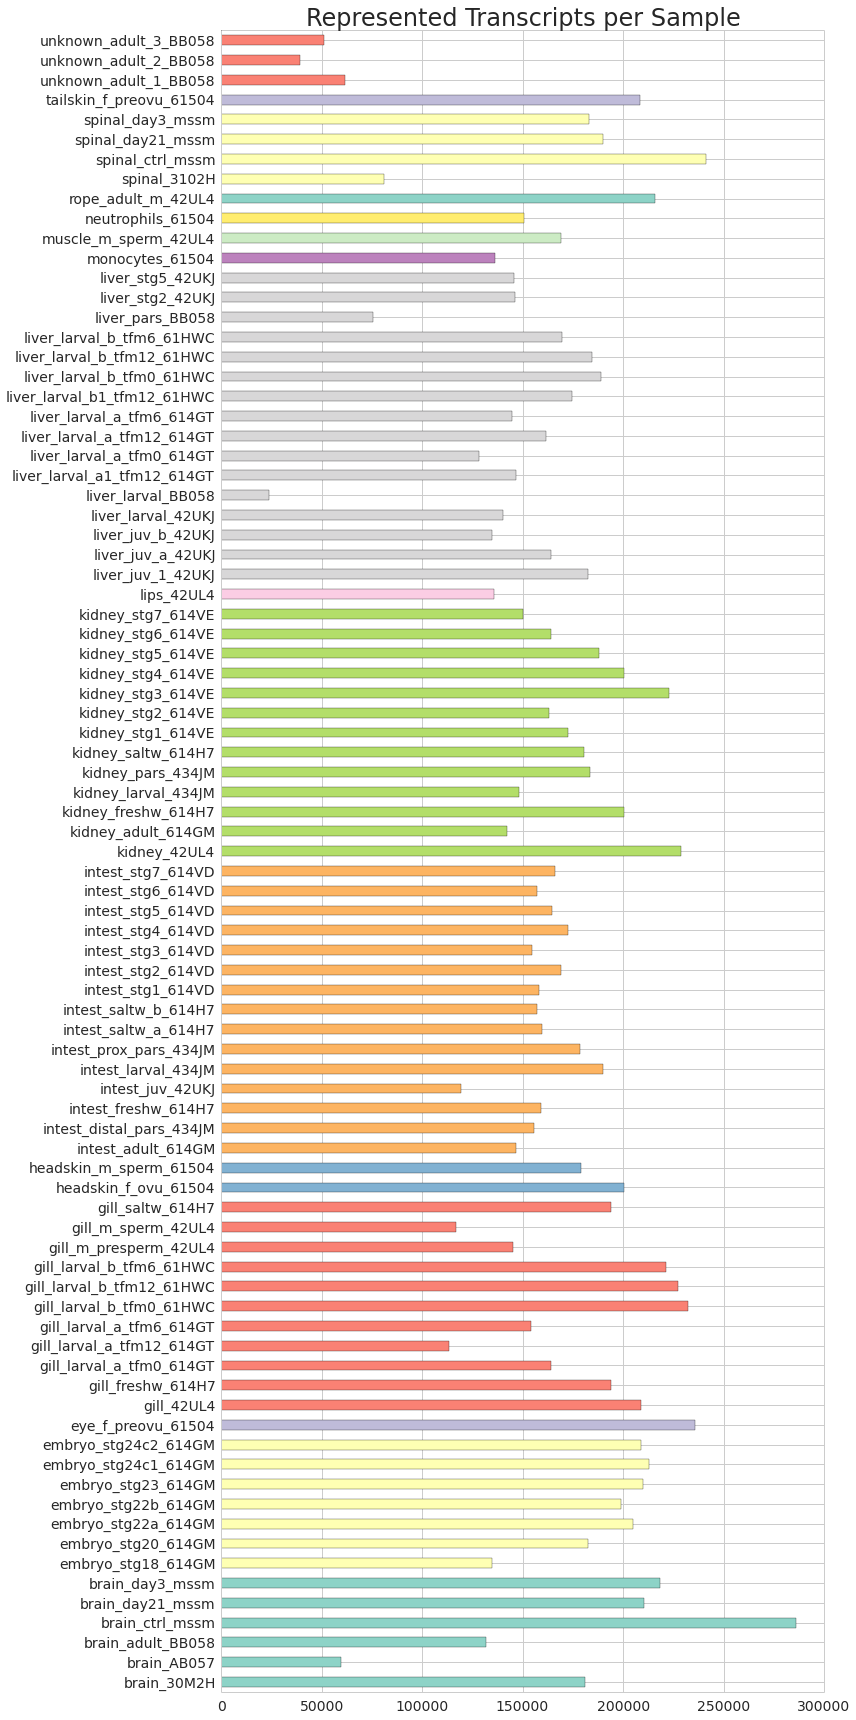

/w/lamprey/lamp3/2013-lamprey/notebooks/analyses/lamp03_transcripts_per_sample.svg

In [18]:
with FigManager(prefix + 'transcripts_per_sample', figsize=tall_size, show=True) as (fig, ax):
    iso_support_df.sum().plot(kind='barh', color=labels_df.color, fontsize=14, figure=fig, ax=ax)
    ax.set_title('Represented Transcripts per Sample')
FileLink(prefix + 'transcripts_per_sample.svg')

### Sample-specific Transcripts

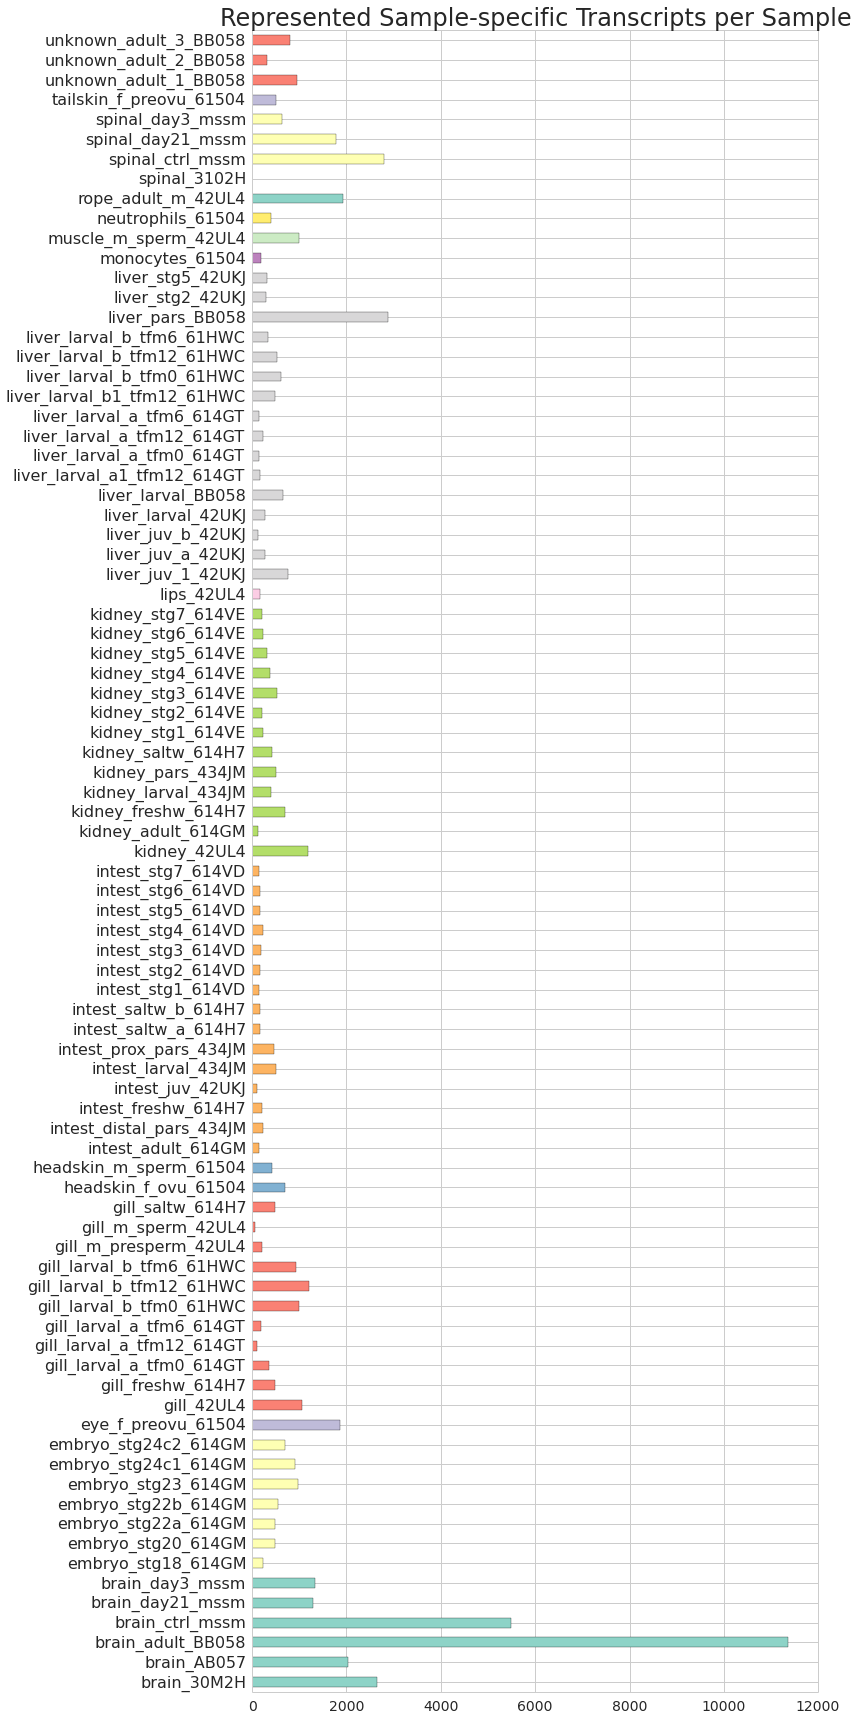

/w/lamprey/lamp3/2013-lamprey/notebooks/analyses/lamp03_sample_specific_transcripts.svg

In [19]:
with FigManager(prefix + 'sample_specific_transcripts', figsize=tall_size, show=True) as (fig, ax):
    iso_support_df[iso_support_df.sum(axis=1) == 1].sum().plot(kind='barh', 
                                                               color=labels_df.color, 
                                                               fontsize=16,
                                                               figure=fig, ax=ax)
    ax.set_title('Represented Sample-specific Transcripts per Sample')
FileLink(prefix + 'sample_specific_transcripts.svg')

In [20]:
with FigManager(prefix + 'multi_transcripts', figsize=tall_size) as (fig, ax):
    iso_support_df[iso_support_df.sum(axis=1) > 1].sum().plot(kind='barh', 
                                                                  color=labels_df.color, 
                                                                  fontsize=16,
                                                                  figure=fig, ax=ax)
    ax.set_title('Represented Sample-nonspecific Transcripts per Sample')
FileLink(prefix + 'multi_transcripts.svg')

/w/lamprey/lamp3/2013-lamprey/notebooks/analyses/lamp03_multi_transcripts.svg

### Sample-representation Distributions

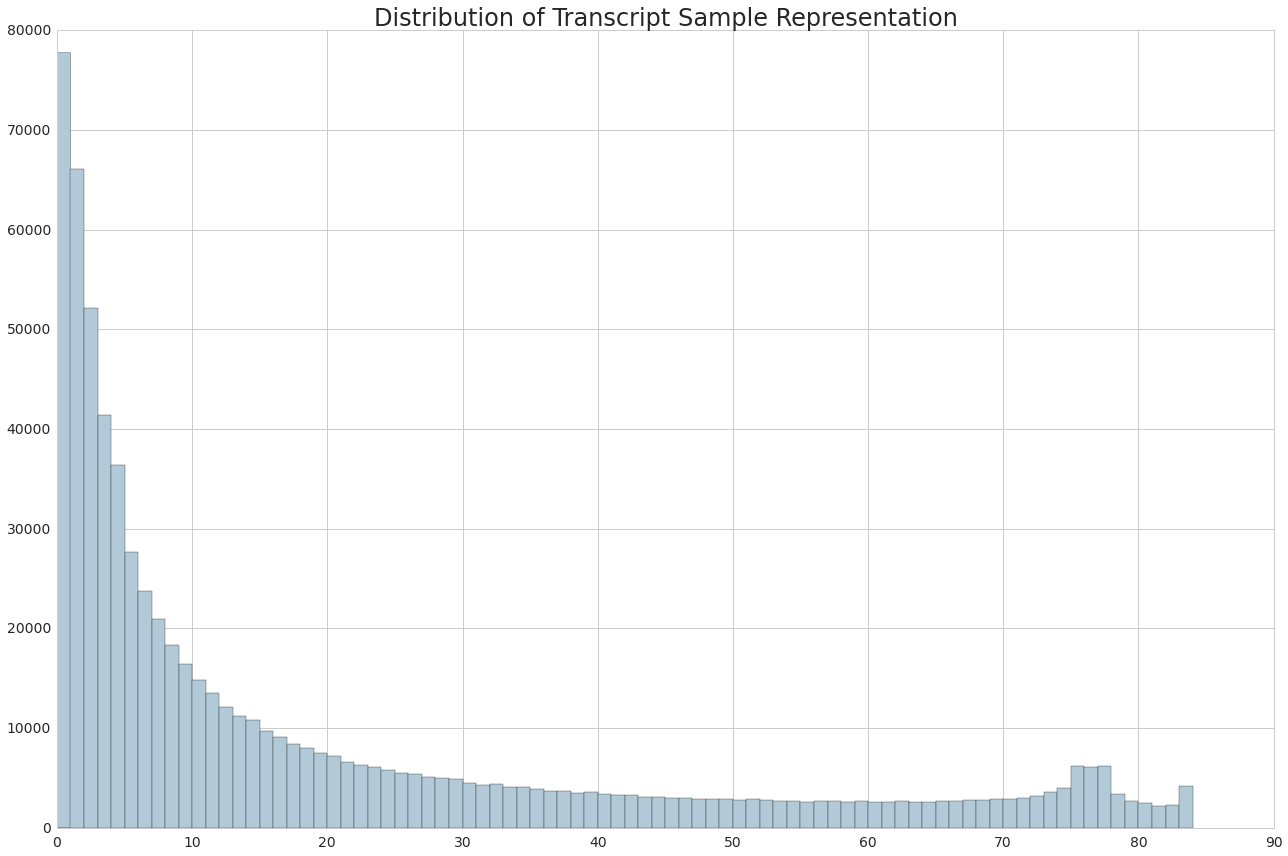

/w/lamprey/lamp3/2013-lamprey/notebooks/analyses/lamp03_transcript_sample_dist.svg

In [21]:
with FigManager(prefix + 'transcript_sample_dist', figsize=norm_size, show=True) as (fig, ax):
    iso_support_df.sum(axis=1).hist(bins=len(iso_support_df.columns),
                                      figure=fig, ax=ax)
    ax.set_title('Distribution of Transcript Sample Representation')
FileLink(prefix + 'transcript_sample_dist.svg')

### Per-Sample Transcript Sample-Representation Distributions

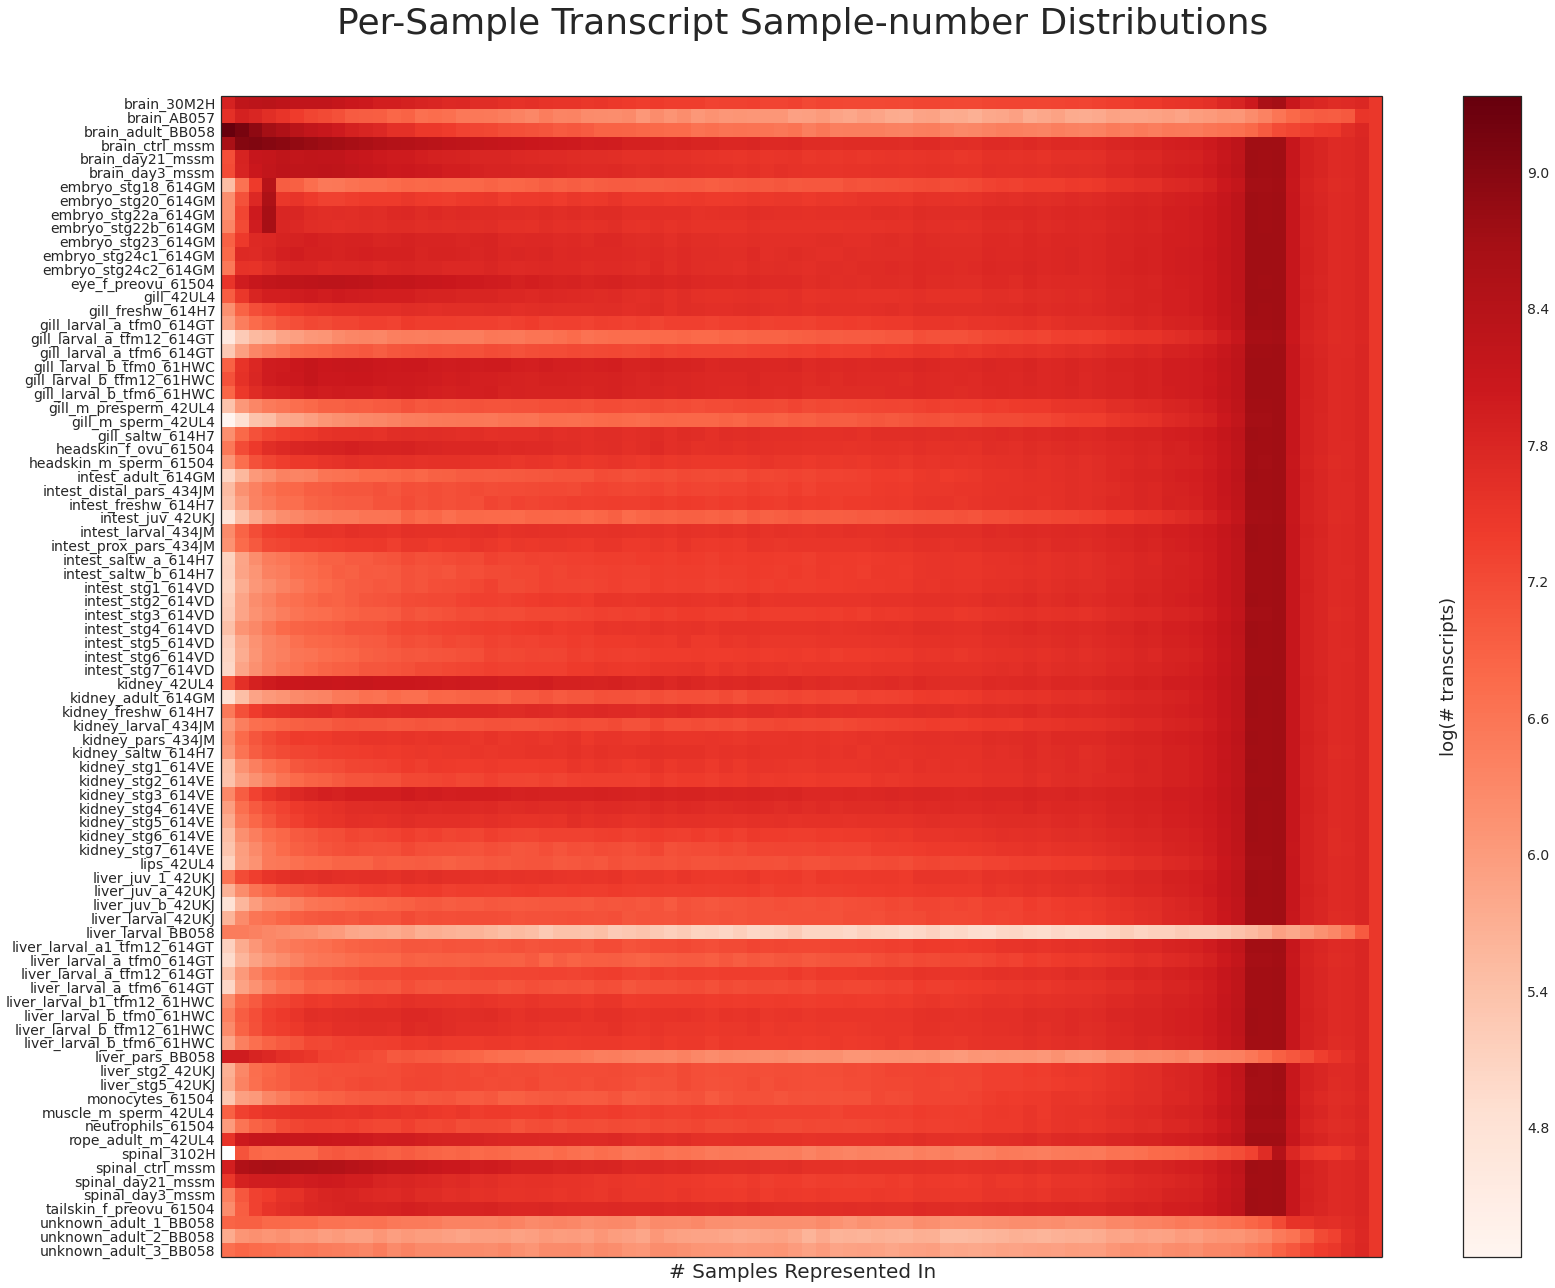

/w/lamprey/lamp3/2013-lamprey/notebooks/analyses/lamp03_per_sample_transcript_sample_dist.svg

In [22]:
def per_sample_hist():
    counts = iso_support_df.sum(axis=1)
    hfunc = lambda s: np.bincount(counts[s == True])[1:]
    with FigManager(prefix + 'per_sample_transcript_sample_dist', sns_style='white', 
                    figsize=(24,18), show=True) as (fig, ax):
        
        tmp = pd.DataFrame({col: np.log(hfunc(iso_support_df[col])) for col in iso_support_df})
        im = ax.matshow(tmp.transpose(), cmap=plt.cm.Reds)
        ax.set_yticks(np.arange(len(tmp.columns)), minor=False,);
        ax.set_yticklabels(tmp.columns, minor=False, fontsize=14,)
        ax.yaxis.tick_left()
        ax.set_xticks([])
        axcolor = fig.add_axes()#[0.95,0.1,0.01,0.8])
        cb = colorbar(im, cax=axcolor,ax=ax)
        ax.set_xlabel('# Samples Represented In', fontsize=20)
        cb.ax.set_ylabel('log(# transcripts)', fontsize=18)
        cb.ax.yaxis.set_label_position('left')
        ax.set_title('Per-Sample Transcript Sample-number Distributions', fontsize=36)
        
per_sample_hist()
FileLink(prefix + 'per_sample_transcript_sample_dist.svg')

### Transcript Sample-Number Distributions for Selected Tissues

In [25]:
def sample_dist_func(sample1='brain_30M2H ', sample2='None', sample3='None'):
    
    with sns.color_palette('Set2'), FigManager(prefix + 'selected_transcript_sample_dist', sns_style='white', 
                    figsize=norm_size, show=True) as (fig, ax):
        counts = iso_support_df.sum(axis=1)

        if sample1 is not 'None':
            ax.plot(np.bincount(counts[iso_support_df[sample1] == True]), lw=3, label=sample1)
        if sample2 is not 'None':
            ax.plot(np.bincount(counts[iso_support_df[sample2] == True]), lw=3, label=sample2)
        if sample3 is not 'None':
            ax.plot(np.bincount(counts[iso_support_df[sample3] == True]), lw=3, label=sample3)

        ax.legend(fontsize=14)
        ax.set_xlim(0,84)
        ax.set_xlabel('# Samples Represented In')
        ax.set_ylabel('# Transcripts')
        ax.set_title('Transcript Sample-number Distributions: Selected Tissues')
        
d = interactive(sample_dist_func, sample1=widgets.SelectWidget(values=['None'] + list(labels_df.newname)),
                                    sample2=widgets.SelectWidget(values=['None'] + list(labels_df.newname)),
                                    sample3=widgets.SelectWidget(values=['None'] + list(labels_df.newname)))

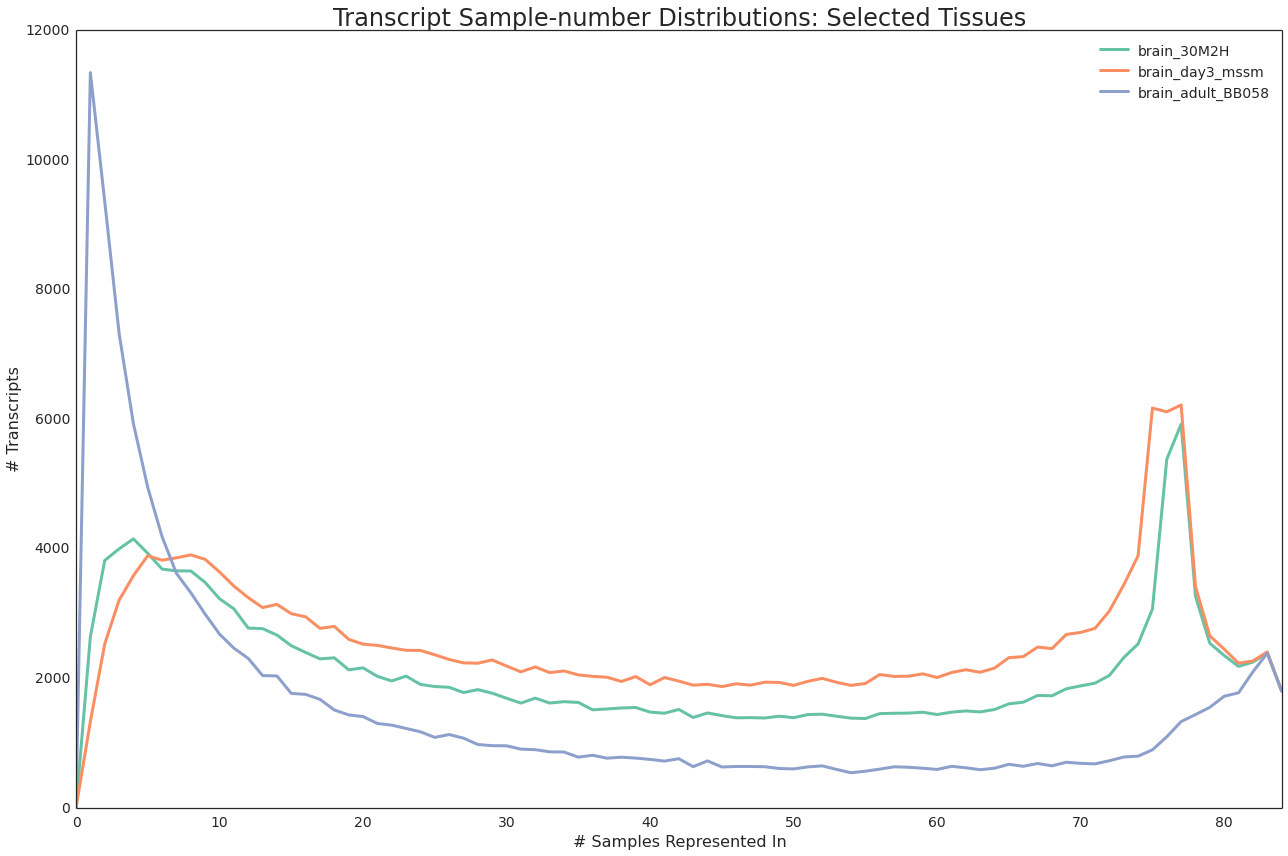

In [26]:
display(d)

### Per Sample Homology and Orthology Support

In [29]:
with sns.color_palette('Set2'), FigManager(prefix + 'homologies_per_sample_per_db', figsize=tall_size) as (fig, ax):
    pd.DataFrame({dbname: iso_support_df.loc[blast_df[dbname],:].sum() \
                  for dbname in metadata['urls'].keys() + metadata['queries'].keys() if dbname != 'assembly'
         }).plot(kind='barh',
                 fontsize=16,
                 figure=fig, ax=ax)
    ax.set_title('Homologies per Sample per Database')
FileLink(prefix + 'homologies_per_sample_per_db.svg')

/w/lamprey/lamp3/2013-lamprey/notebooks/analyses/lamp03_homologies_per_sample_per_db.svg

In [44]:
def plot_db_func(db='musMus_pep', dbtype='Homologies', metric='Count'):
    fn = '{}{}_{}_per_sample_{}'.format(prefix, db, dbtype, metric)
    with FigManager(fn, figsize=tall_size, show=True) as (fig, ax):
        
        if dbtype == 'Homologies':
            filt = blast_df[db]
        else:
            filt = ortho_df[db]
            
        ax.set_title('{} {} per Sample [{}]'.format(db, dbtype, metric))
        
        if metric == 'Count':
            pd.DataFrame({'transcripts': iso_support_df.sum(), 'hits': iso_support_df.loc[filt,:].sum(),
                     }).plot(kind='barh', fontsize=16, figure=fig, ax=ax)
        else:
            (100.0 * iso_support_df.loc[filt,:].sum() \
             / iso_support_df.sum()).plot(kind='barh', 
                                      color=labels_df.color, 
                                      fontsize=16,
                                      figure=fig, ax=ax)
            ax.set_xlim(0, 100)
            
    FileLink(fn + '.svg')

d = interactive(plot_db_func, db=widgets.SelectWidget(values=[dbname for dbname in \
                                                              metadata['urls'].keys() + metadata['queries'].keys() \
                                                              if dbname != 'assembly']),
                dbtype=widgets.RadioButtonsWidget(values=['Homologies', 'Orthologies']),
                metric=widgets.RadioButtonsWidget(values=['Count', 'Percentage']))

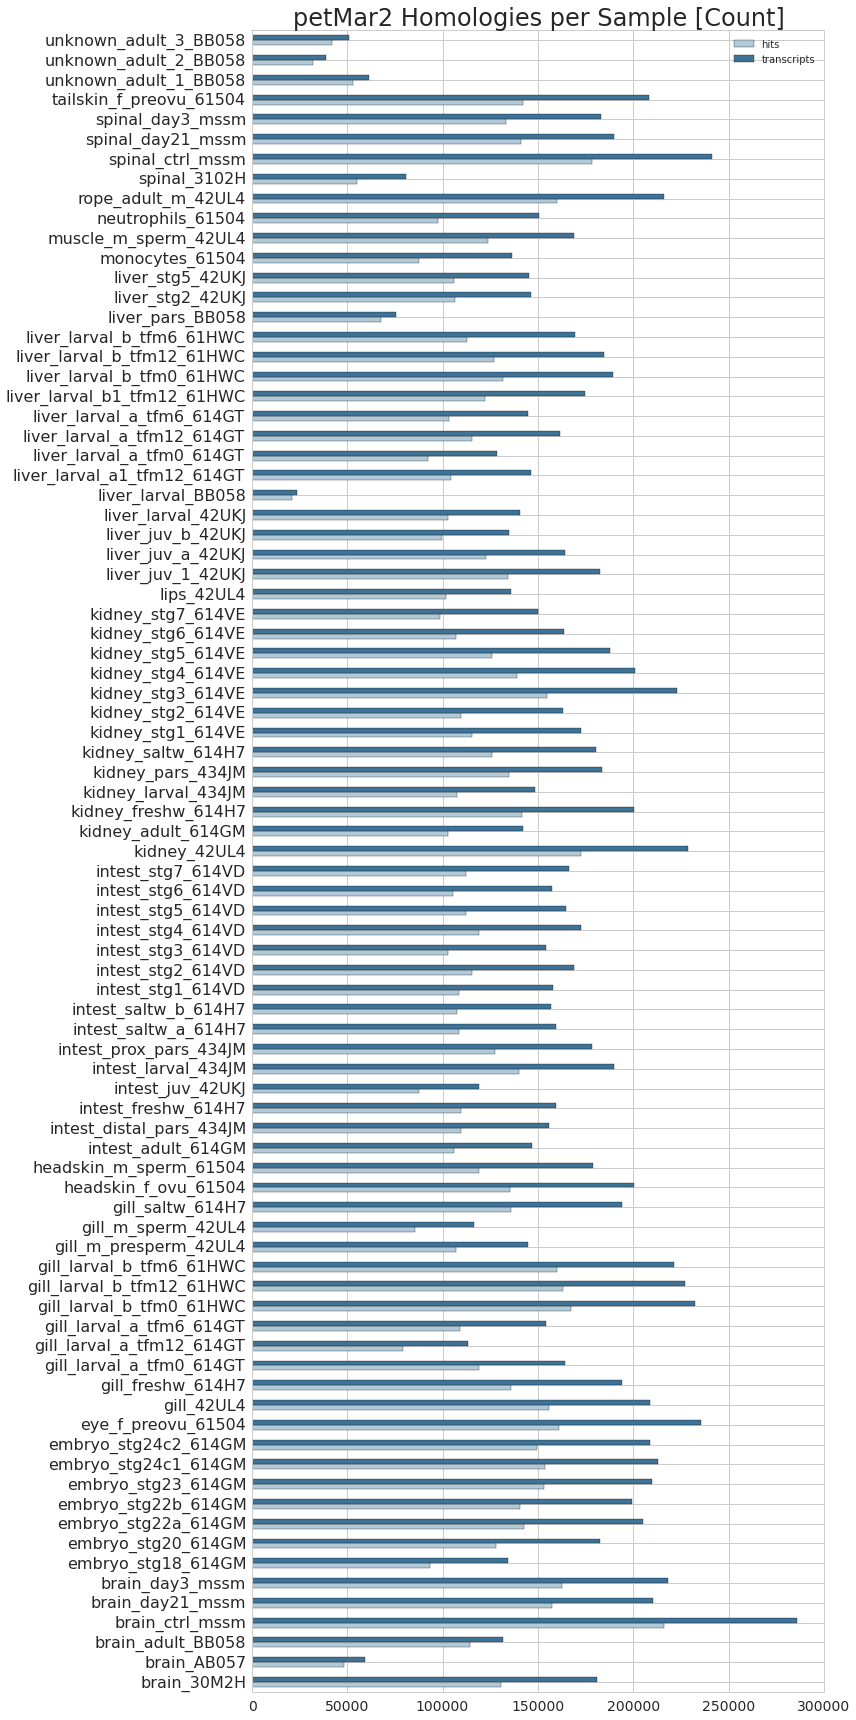

In [45]:
display(d)

### Percentage of Transcripts with Any Homology per Sample

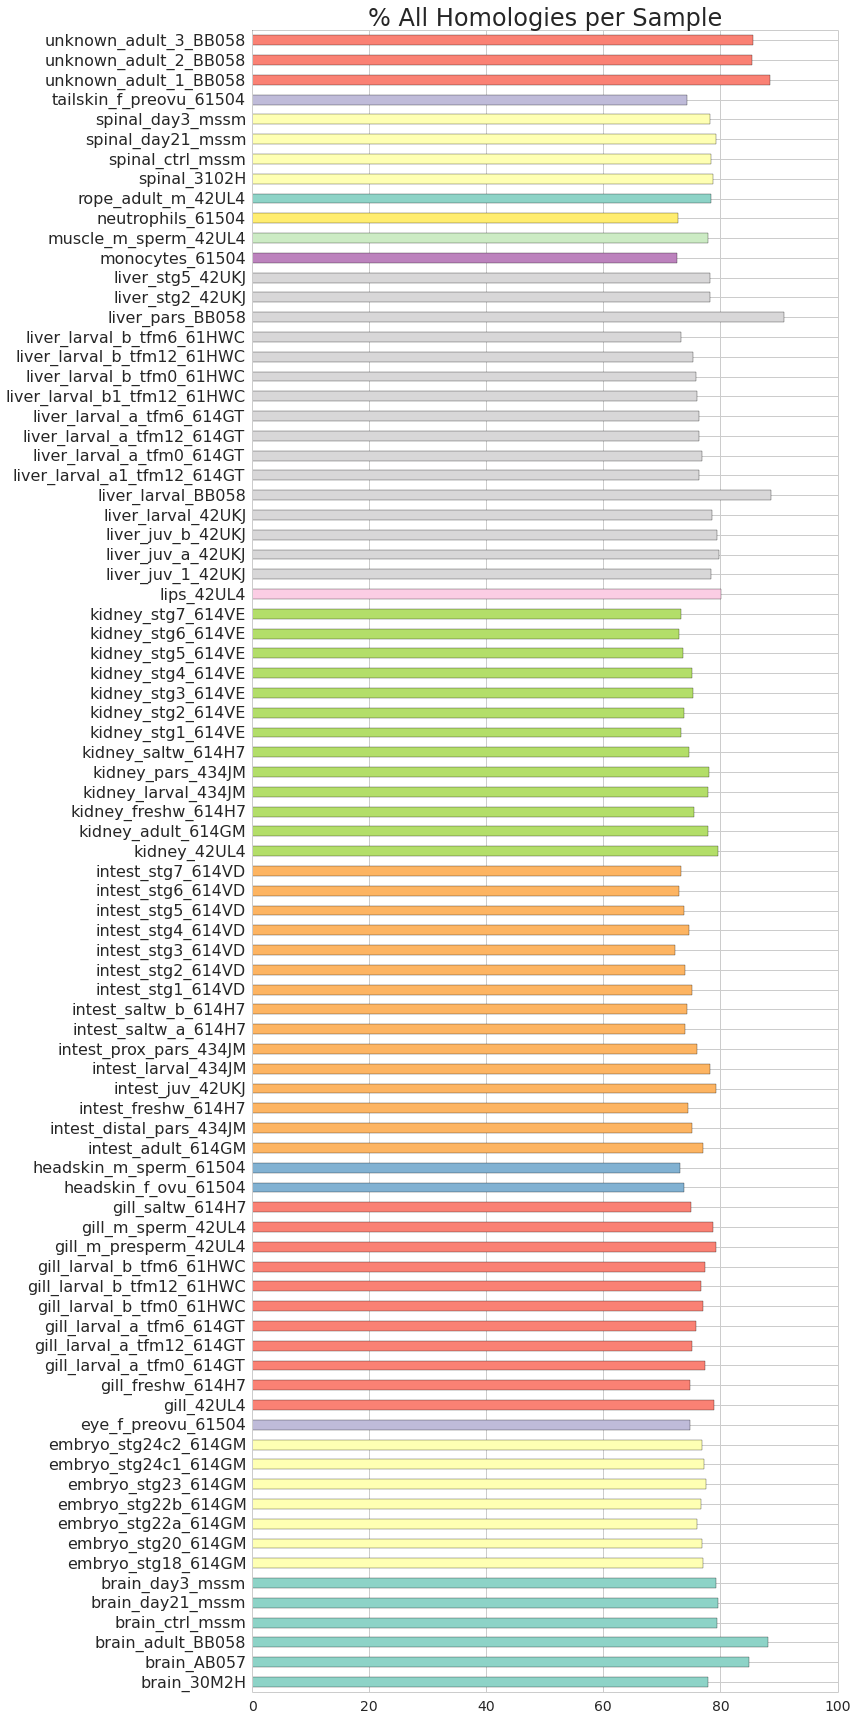

/w/lamprey/lamp3/2013-lamprey/notebooks/analyses/lamp03_all_hits_per_sample.svg

In [46]:
with FigManager(prefix + 'all_hits_per_sample', figsize=tall_size, show=True) as (fig, ax):
    (100.0 * iso_support_df.loc[putative_df.homology,:].sum() \
         / iso_support_df.sum()).plot(kind='barh', 
                                      color=labels_df.color, 
                                      fontsize=16,
                                      figure=fig, ax=ax)
    ax.set_xlim(0, 100)
    ax.set_title('% All Homologies per Sample')
FileLink(prefix + 'all_hits_per_sample.svg')

### Percentage of Transcripts with Any Orthology per Sample

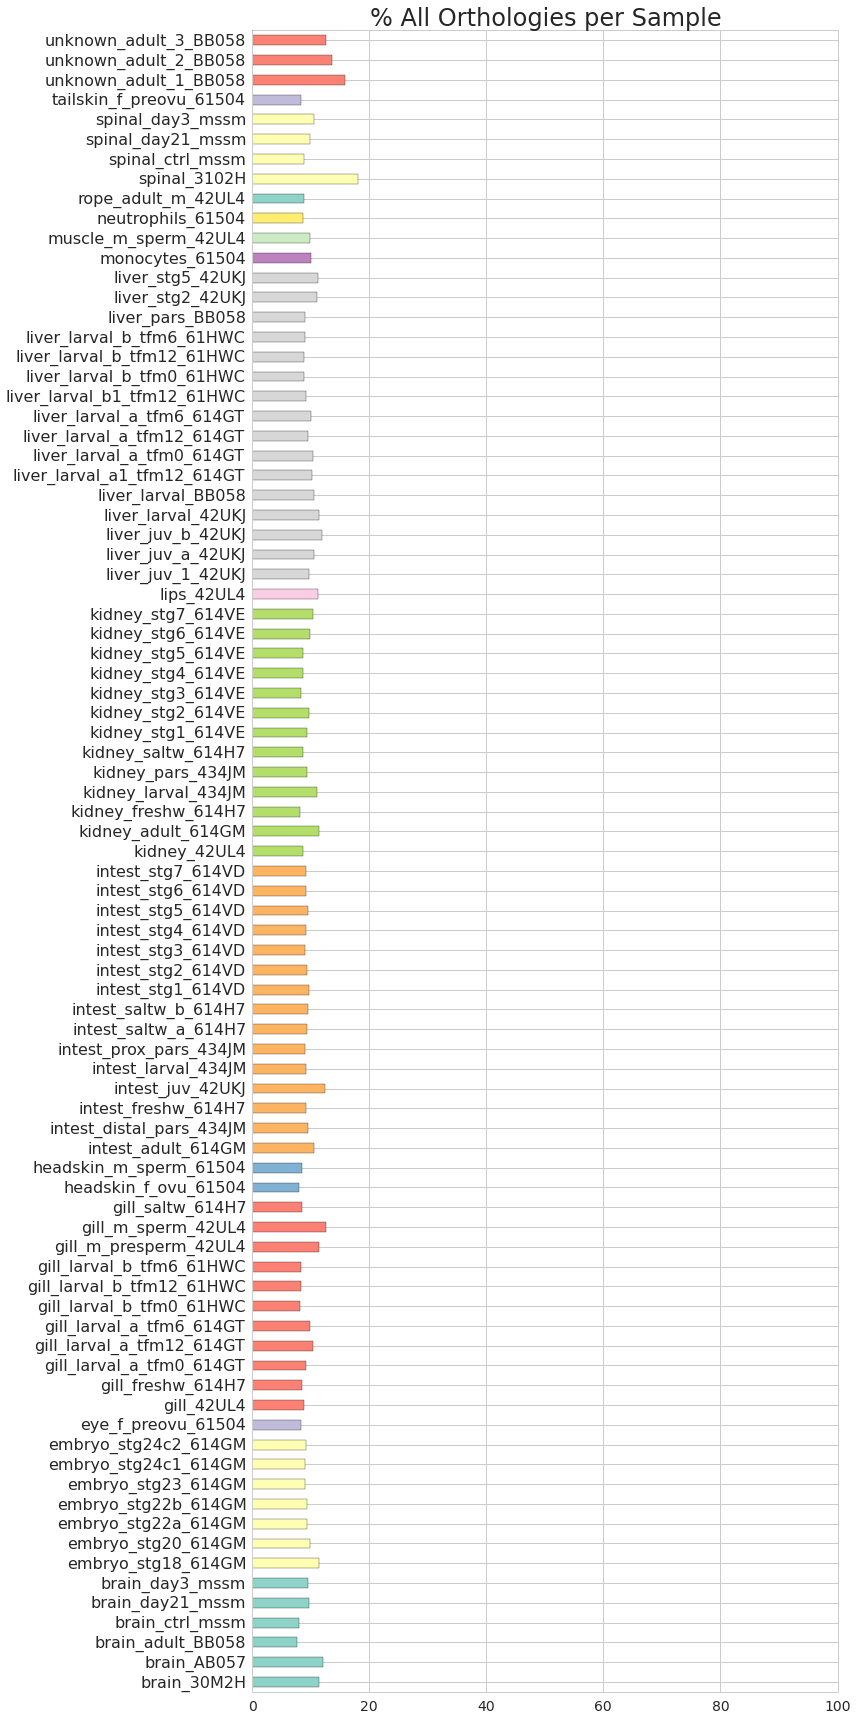

/w/lamprey/lamp3/2013-lamprey/notebooks/analyses/lamp03_all_ortho_per_sample.svg

In [47]:
with FigManager(prefix + 'all_ortho_per_sample', figsize=tall_size, show=True) as (fig, ax):
    (100.0 * iso_support_df.loc[putative_df.orthology,:].sum() \
         / iso_support_df.sum()).plot(kind='barh', 
                                      color=labels_df.color, 
                                      fontsize=16,
                                      figure=fig, ax=ax)
    ax.set_xlim(0, 100)
    ax.set_title('% All Orthologies per Sample')
FileLink(prefix + 'all_ortho_per_sample.svg')

### Putative Transcripts Novel to lamp00

In [52]:
putative_df.not_lamp00.sum()

597536

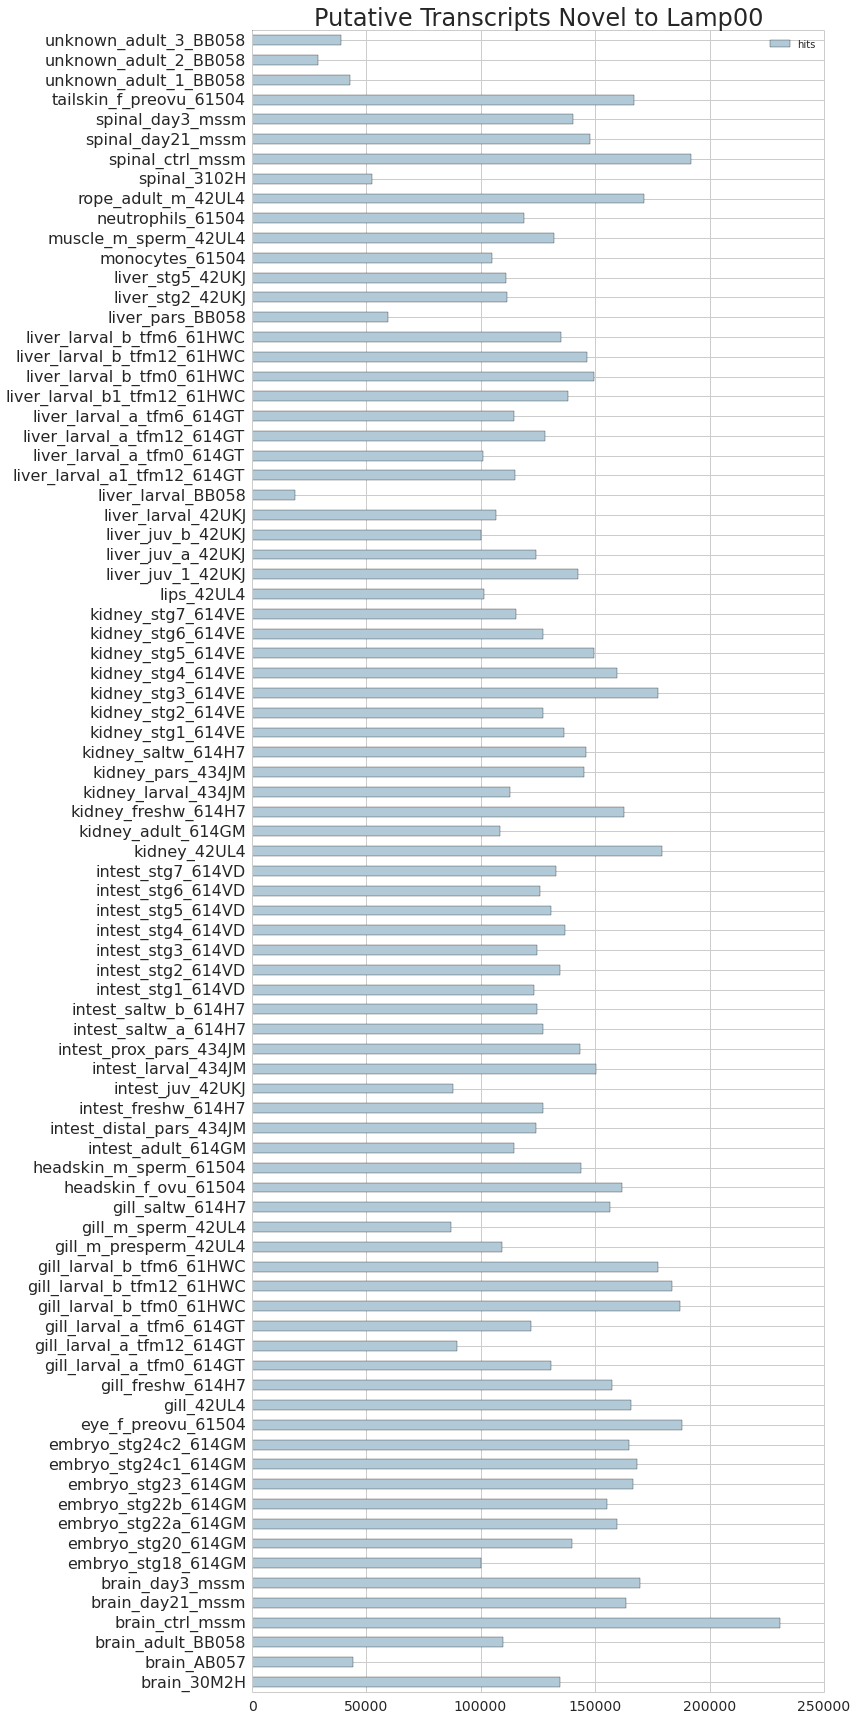

/w/lamprey/lamp3/2013-lamprey/notebooks/analyses/lamp03_putative_notlamp00.svg

In [50]:
with FigManager(prefix + 'putative_notlamp00', figsize=tall_size, show=True) as (fig, ax):
    pd.DataFrame({'hits': iso_support_df.loc[putative_df.not_lamp00,:].sum(),
         }).plot(kind='barh',
                 fontsize=16,
                 figure=fig, ax=ax)
    ax.set_title('Putative Transcripts Novel to Lamp00')
FileLink(prefix + 'putative_notlamp00.svg')

### Putative Transcripts Novel to Lamprey

These are transcripts not represented in any existing lamprey resources; this includes within the genome.

In [53]:
putative_df.novel.sum()

158218

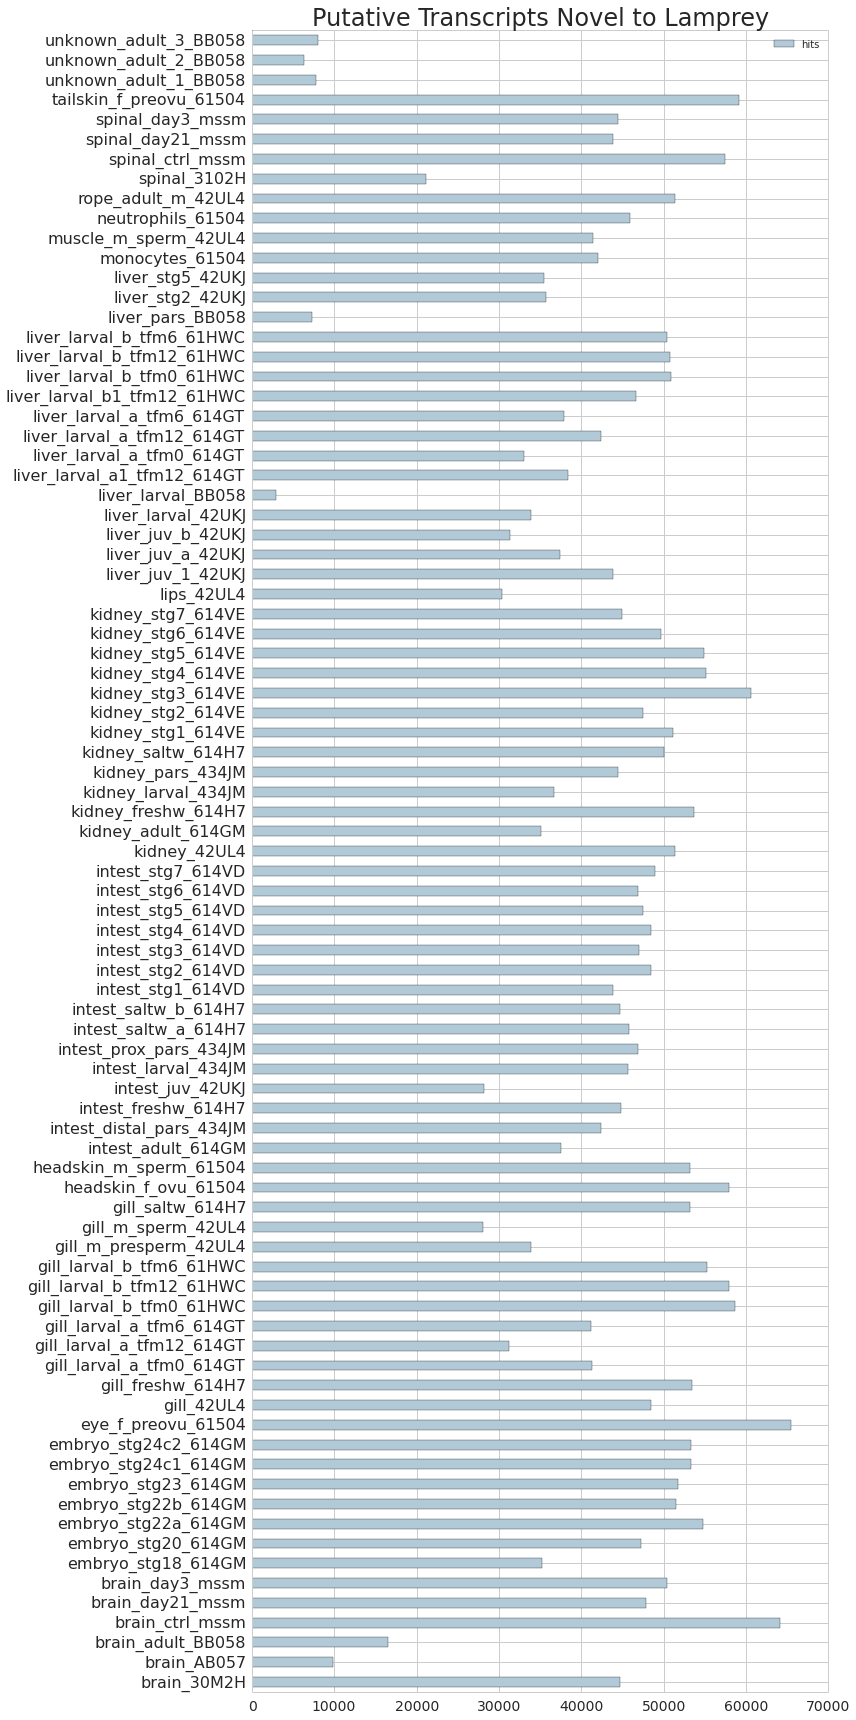

/w/lamprey/lamp3/2013-lamprey/notebooks/analyses/lamp03_putative_novel.svg

In [54]:
with FigManager(prefix + 'putative_novel', figsize=tall_size, show=True) as (fig, ax):
    pd.DataFrame({'hits': iso_support_df.loc[putative_df.novel,:].sum(),
         }).plot(kind='barh',
                 fontsize=16,
                 figure=fig, ax=ax)
    ax.set_title('Putative Transcripts Novel to Lamprey')
FileLink(prefix + 'putative_novel.svg')

In [55]:
(putative_df.novel & (iso_support_df.sum(axis=1) == 1)).sum()

10322

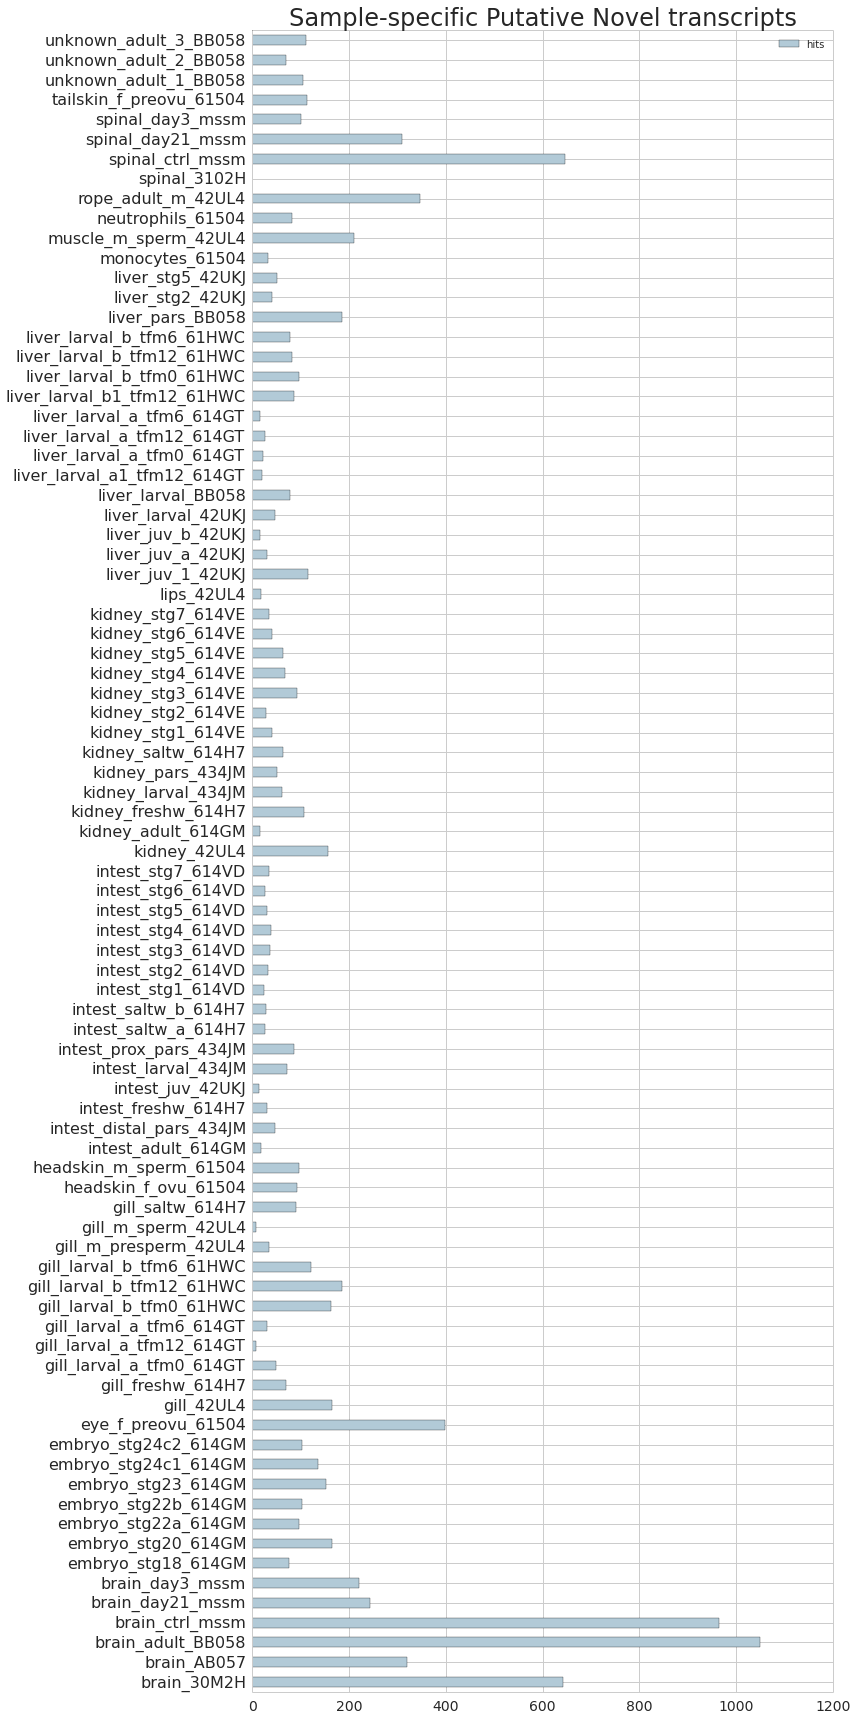

/w/lamprey/lamp3/2013-lamprey/notebooks/analyses/lamp03_sample_specific_novel.svg

In [48]:
with FigManager(prefix + 'sample_specific_novel', figsize=tall_size, show=True) as (fig, ax):
    pd.DataFrame({'hits': iso_support_df.loc[putative_df.novel & \
                                (iso_support_df.sum(axis=1) == 1),:].sum(),
         }).plot(kind='barh',
                 fontsize=16,
                 figure=fig, ax=ax)
    ax.set_title('Sample-specific Putative Novel transcripts')
FileLink(prefix + 'sample_specific_novel.svg')

## Tissue-level Analysis

### Transcripts per Tissue

In [59]:
tissue_support_df.sum()

brain          424092
embryo         363969
eye            235551
gill           411831
headskin       239642
intest         380257
kidney         414267
lips           135685
liver          413133
monocytes      136131
muscle         169121
neutrophils    150724
rope           216074
spinal         320946
tailskin       208446
unknown         89454
dtype: int64

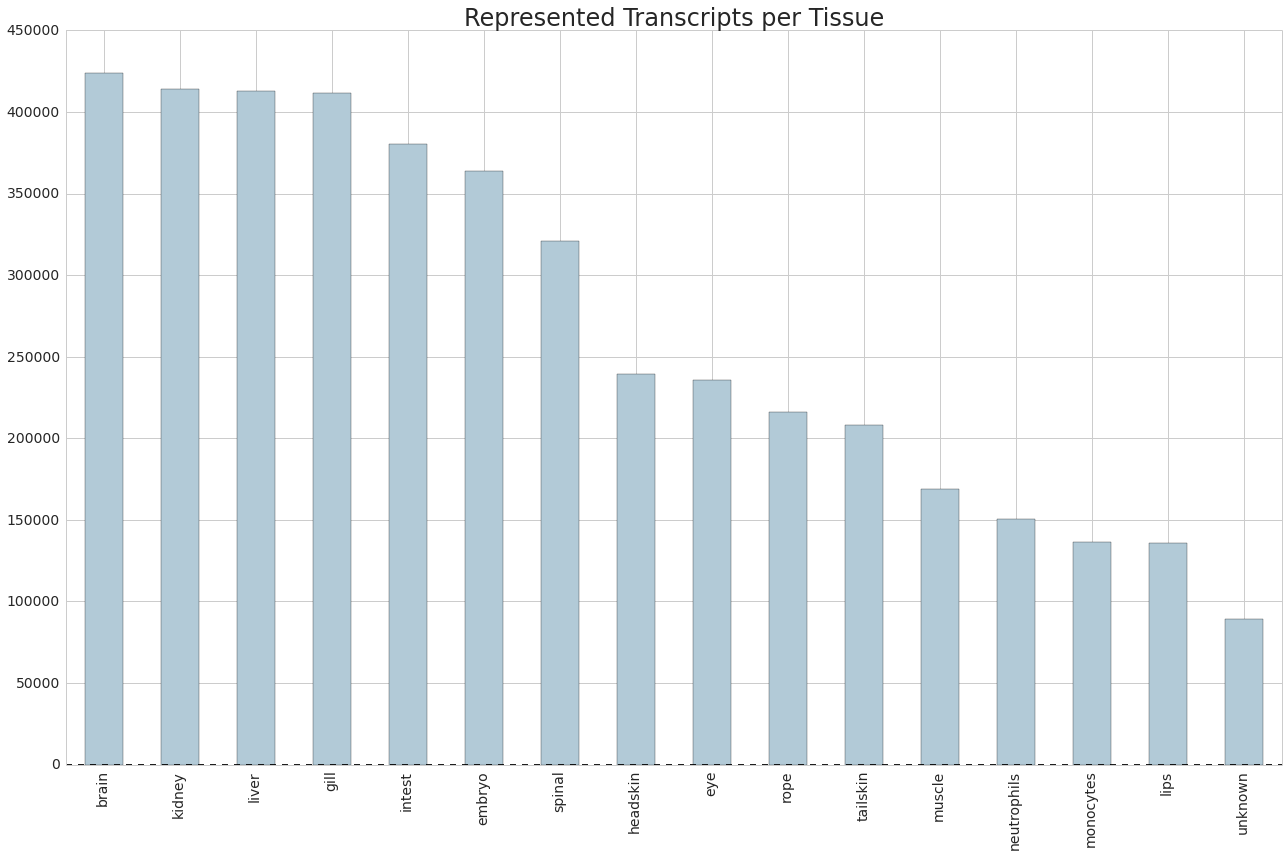

/w/lamprey/lamp3/2013-lamprey/notebooks/analyses/lamp03_transcripts_per_tissue.svg

In [60]:
with FigManager(prefix + 'transcripts_per_tissue', figsize=norm_size, show=True) as (fig, ax):
    tissue_support_df.sum().order(ascending=False).plot(kind='bar', fontsize=14, figure=fig, ax=ax)
    ax.set_title('Represented Transcripts per Tissue')
FileLink(prefix + 'transcripts_per_tissue.svg')

### Tissue-specific Transcripts

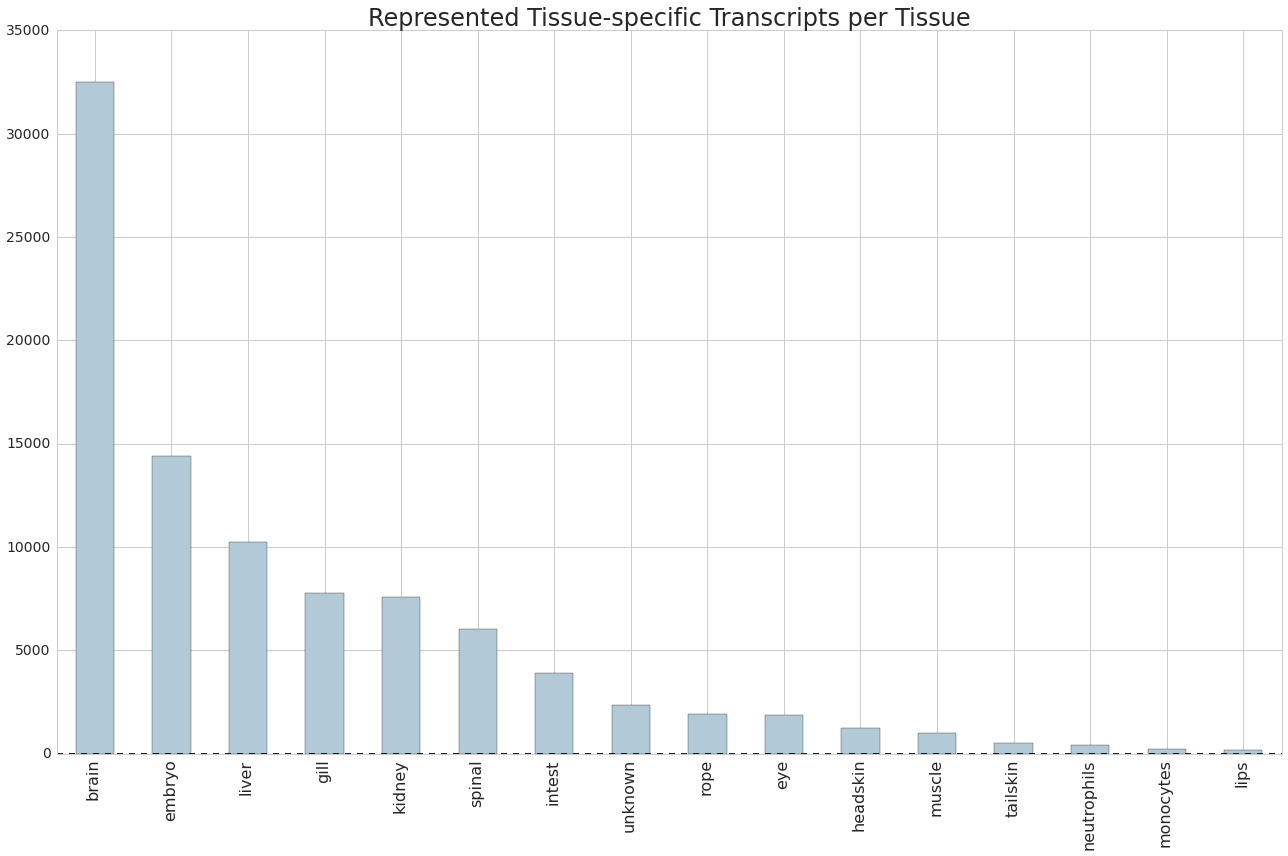

/w/lamprey/lamp3/2013-lamprey/notebooks/analyses/lamp03_tissue_specific_transcripts.svg

In [61]:
with FigManager(prefix + 'tissue_specific_transcripts', figsize=norm_size, show=True) as (fig, ax):
    tissue_support_df[tissue_support_df.sum(axis=1) == 1].sum().order(ascending=False).plot(kind='bar',
                                                               fontsize=16,
                                                               figure=fig, ax=ax)
    ax.set_title('Represented Tissue-specific Transcripts per Tissue')
FileLink(prefix + 'tissue_specific_transcripts.svg')

### Lamprey Genome Homologies per Tissue

In [78]:
def plot_db_tissue_func(db='musMus_pep', dbtype='Homologies', metric='Count'):
    fn = '{}{}_{}_per_tissue_{}'.format(prefix, db, dbtype, metric)
    with FigManager(fn, figsize=norm_size, show=True) as (fig, ax):
        
        if dbtype == 'Homologies':
            filt = blast_df[db]
        else:
            filt = ortho_df[db]
            
        ax.set_title('{} {} per Tissue [{}]'.format(db, dbtype, metric))
        
        if metric == 'Count':
            tissue_support_df.loc[filt,:].sum().order(ascending=False).plot(kind='bar', fontsize=16, figure=fig, ax=ax)
        else:
            (100.0 * tissue_support_df.loc[filt,:].sum() / \
                  tissue_support_df.sum()).order(ascending=False).plot(kind='bar', fontsize=16, figure=fig, ax=ax)
            ax.set_ylim(0, 100)
            
    FileLink(fn + '.svg')

d = interactive(plot_db_tissue_func, db=widgets.SelectWidget(values=[dbname for dbname in \
                                                              metadata['urls'].keys() + metadata['queries'].keys() \
                                                              if dbname != 'assembly']),
                dbtype=widgets.RadioButtonsWidget(values=['Homologies', 'Orthologies']),
                metric=widgets.RadioButtonsWidget(values=['Count', 'Percentage']))

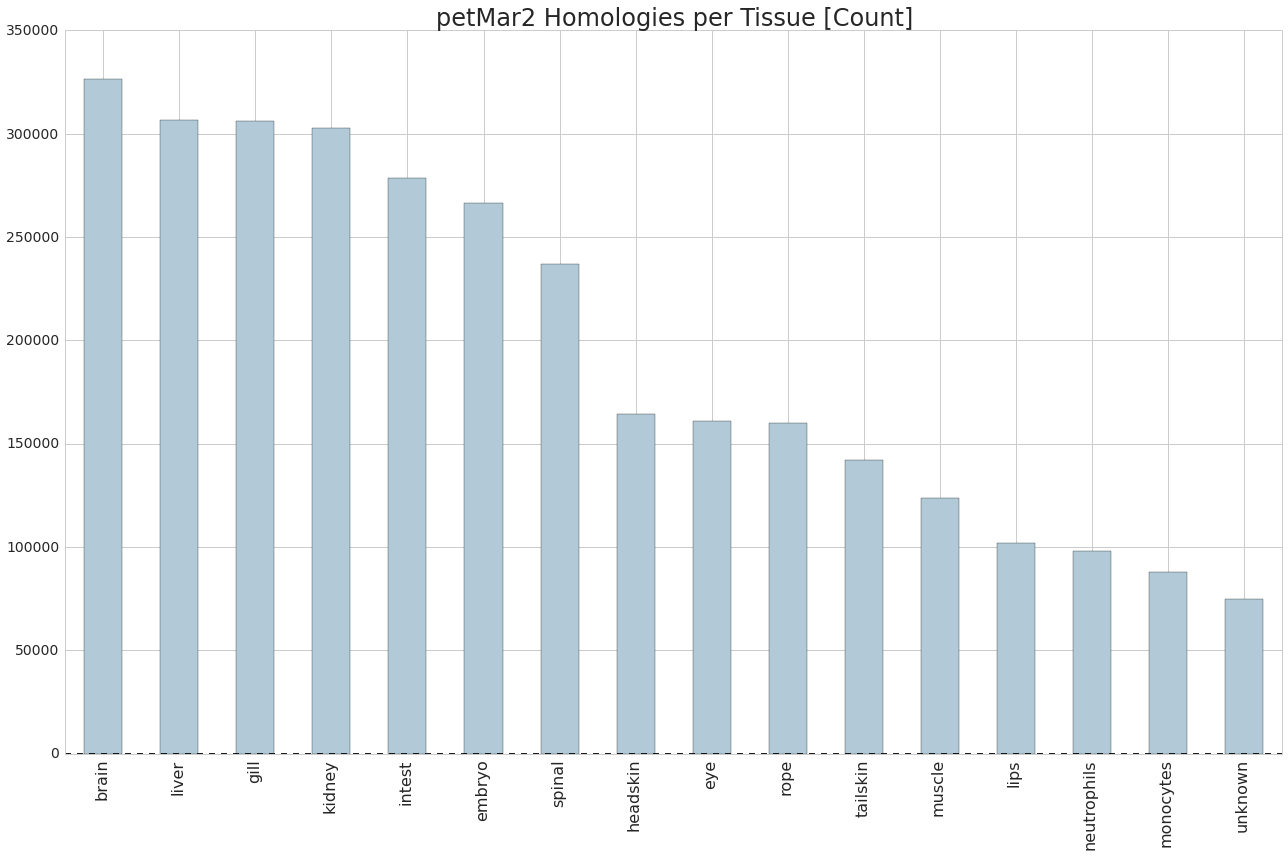

In [79]:
display(d)

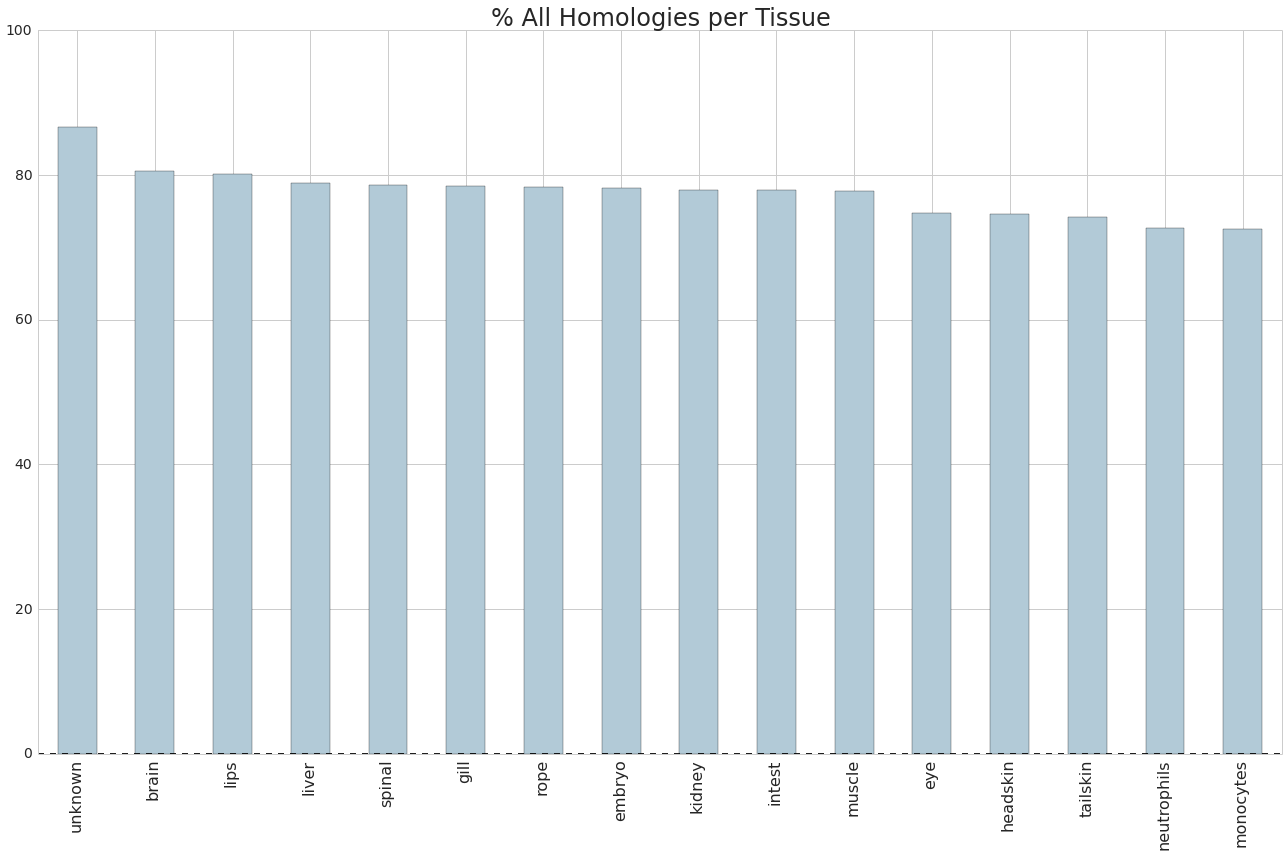

/w/lamprey/lamp3/2013-lamprey/notebooks/analyses/lamp03_all_hits_per_tissue.svg

In [80]:
with FigManager(prefix + 'all_hits_per_tissue', figsize=norm_size, show=True) as (fig, ax):
    (100.0 * tissue_support_df.loc[putative_df.homology,:].sum() \
         / tissue_support_df.sum()).order(ascending=False).plot(kind='bar', 
                                      fontsize=16,
                                      figure=fig, ax=ax)
    ax.set_ylim(0, 100)
    ax.set_title('% All Homologies per Tissue')
FileLink(prefix + 'all_hits_per_tissue.svg')

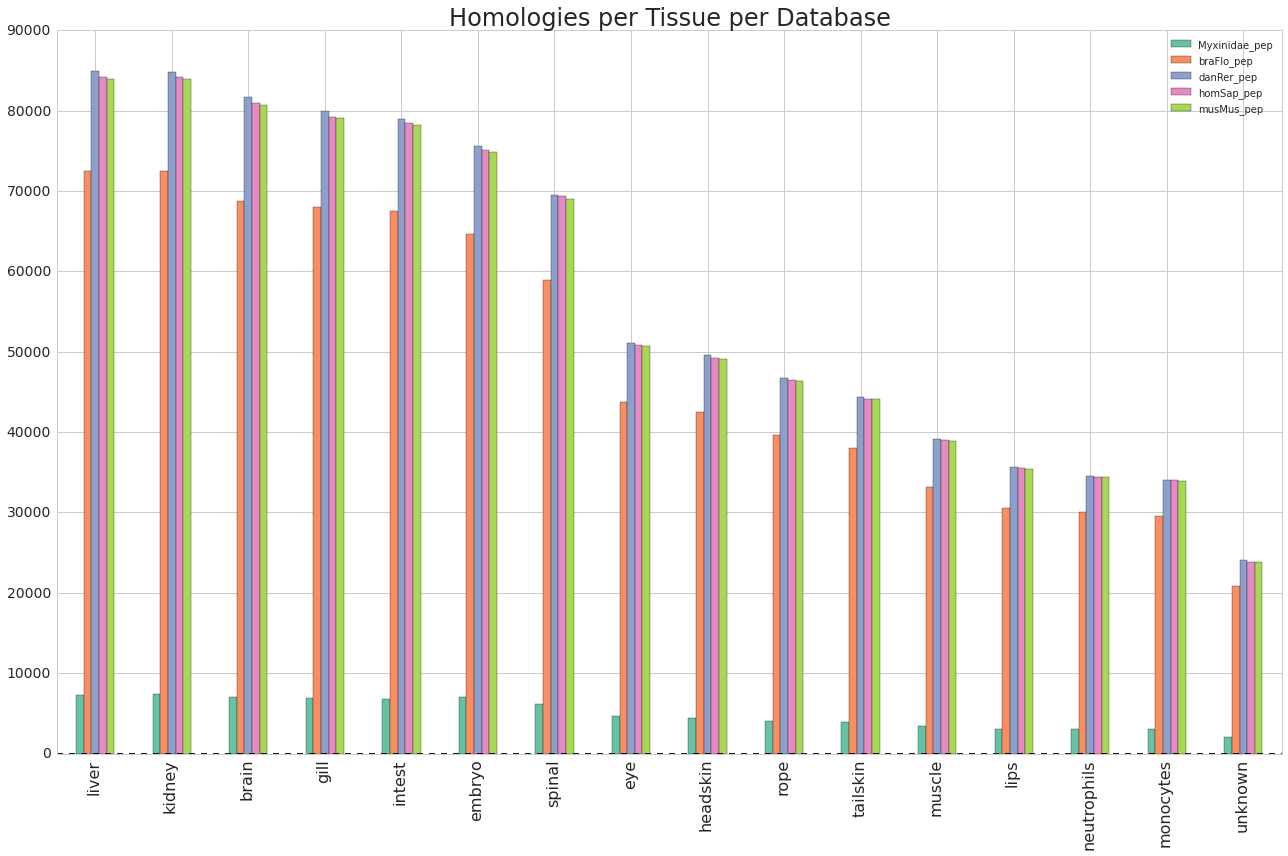

/w/lamprey/lamp3/2013-lamprey/notebooks/analyses/lamp03_homologies_per_tissue_per_db.svg

In [81]:
with sns.color_palette('Set2'), FigManager(prefix + 'homologies_per_tissue_per_db', figsize=norm_size, show=True) as (fig, ax):
    pd.DataFrame({dbname: tissue_support_df.loc[blast_df[dbname],:].sum() \
                  for dbname in metadata['urls'].keys() + metadata['queries'].keys() \
                  if dbname != 'assembly' and 'petMar' not in dbname
         }).sort(columns='danRer_pep', ascending=False).plot(kind='bar',
                 fontsize=16,
                 figure=fig, ax=ax)
    ax.set_title('Homologies per Tissue per Database')
FileLink(prefix + 'homologies_per_tissue_per_db.svg')

## Homology and Orthology-centered Assessment

lamp03 Queries
--------------

* Novel to Lamprey
    * (musMus_pep OR danRer_pep OR braFlo_pep OR homSap_pep OR petMar2_pep) AND NOT petMar2_cds
    * (musMus_pep OR danRer_pep OR braFlo_pep OR homSap_pep OR petMar2_pep) AND NOT (petMar2 OR petMar2_cds)
    * (musMus_pep OR danRer_pep) AND NOT (braFlo_pep OR petMar2_cds)
    * (braFlo_pep) AND NOT (musMus_pep OR danRer_pep OR petMar2_cds)
    * petMar2_pep AND NOT petMar2_cds
    * petMar2_pep AND NOT (petMar2_cds OR petMar2)
    * NOT petMar2 AND petMar3_dna
* Putative
    * (musMus_pep OR danRer_pep OR braFlo_pep OR homSap_pep OR petMar2_pep) AND petMar2
    * (musMus_pep OR danRer_pep OR braFlo_pep OR homSap_pep OR petMar2_pep)

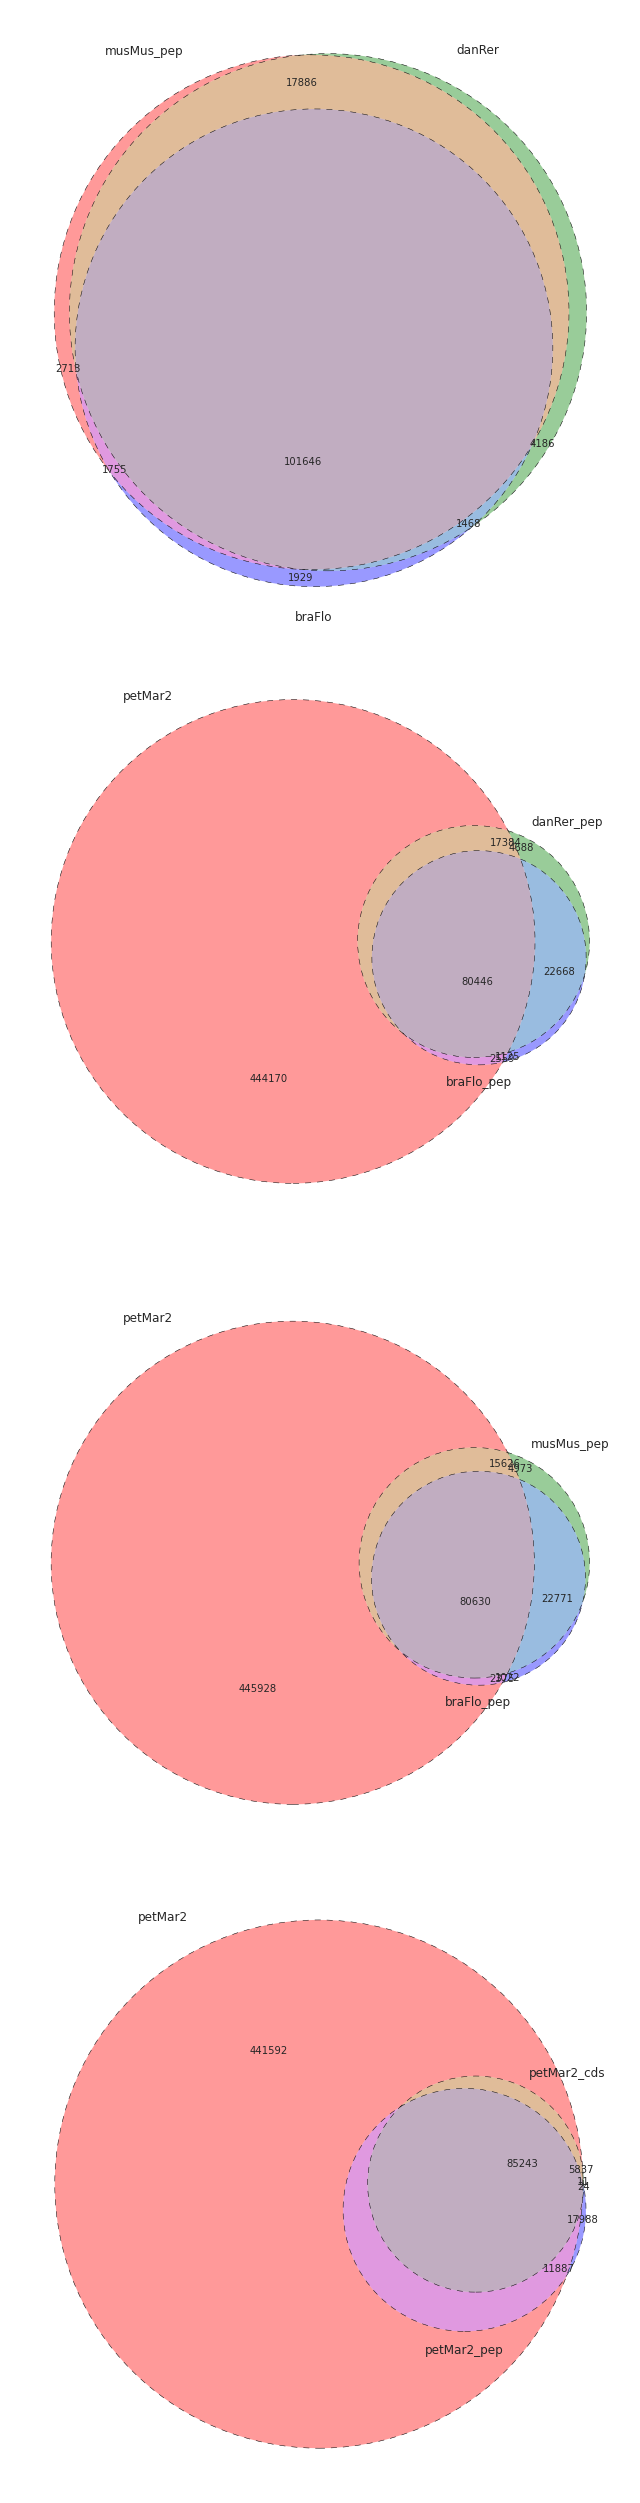

In [82]:
with sns.color_palette('Set2'), \
    FigManager('musmus_danrer_braflo_venn1', figsize=(9,36), nrows=4, ncols=1, show=True) as (fig, ax):
        
    ss = [([set(blast_df.index[blast_df.musMus_pep]),
           set(blast_df.index[blast_df.danRer_pep]),
           set(blast_df.index[blast_df.braFlo_pep])],
            ['musMus_pep', 'danRer', 'braFlo']),
            
          ([set(blast_df.index[blast_df.petMar2]),
           set(blast_df.index[blast_df.danRer_pep]),
           set(blast_df.index[blast_df.braFlo_pep])],
            ['petMar2', 'danRer_pep', 'braFlo_pep']),
    
          ([set(blast_df.index[blast_df.petMar2]),
           set(blast_df.index[blast_df.musMus_pep]),
           set(blast_df.index[blast_df.braFlo_pep])],
            ['petMar2', 'musMus_pep', 'braFlo_pep']),
    
          ([set(blast_df.index[blast_df.petMar2]),
           set(blast_df.index[blast_df.petMar2_cds]),
           set(blast_df.index[blast_df.petMar2_pep])],
            ['petMar2', 'petMar2_cds', 'petMar2_pep'])]
    
    for i, (subset, labels) in enumerate(ss):
        venn3(subsets=subset, ax=ax[i], set_labels=labels)
        venn3_circles(subsets=subset, ax=ax[i], linestyle='dashed', linewidth=.5)

ERROR <type 'exceptions.AttributeError'> 'DataFrame' object has no attribute 'additions' <traceback object at 0x7ff158e260e0>


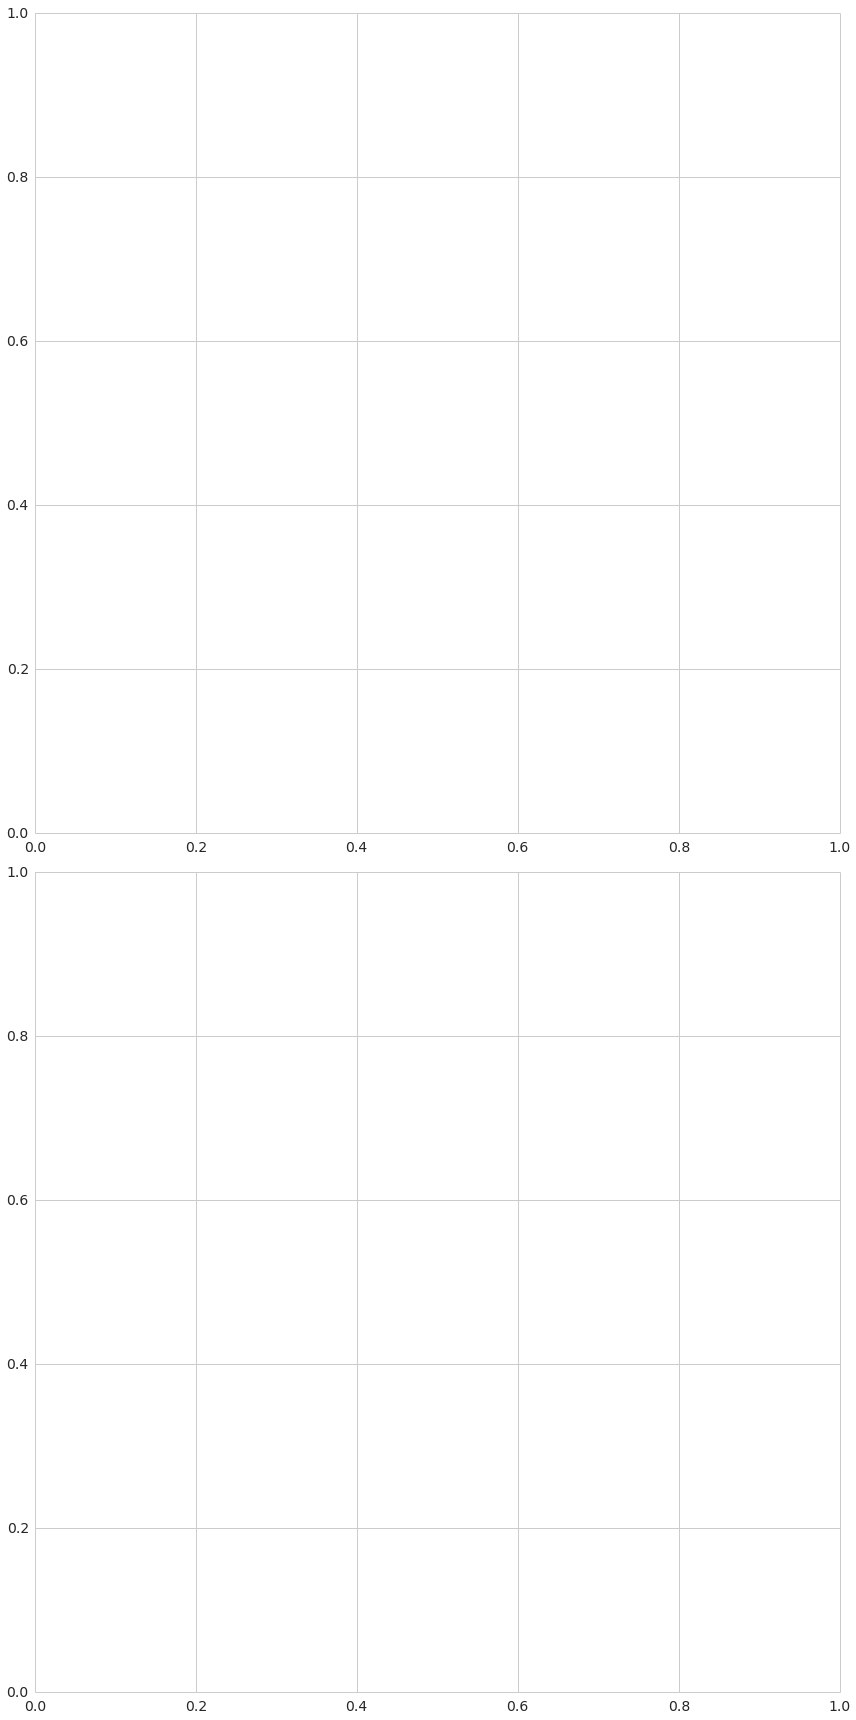

AttributeError: 'DataFrame' object has no attribute 'additions'

In [83]:
with sns.color_palette('Set2'), \
    FigManager('petmar_venn2', figsize=(12,24), nrows=2, ncols=1, show=True) as (fig, ax):
        
    ss = [([set(blast_df.index),
           set(putative_df.index[putative_df.additions]),
           set(putative_df.index[putative_df.novel])],
            ['all', 'additions', 'novel']),
            
          ([set(blast_df.index[blast_df.homSap_pep]),
           set(blast_df.index[blast_df.danRer_pep]),
           set(blast_df.index[blast_df.braFlo_pep])],
            ['homSap_pep', 'danRer_pep', 'braFlo_pep'])]
    
    for i, (subset, labels) in enumerate(ss):
        venn3(subsets=subset, ax=ax[i], set_labels=labels)
        venn3_circles(subsets=subset, ax=ax[i], linestyle='dashed', linewidth=.5)

## Gene Content Assessment

First, we'll load the list of lamprey gene names from the UCSC genome browser.

TODO: Add this file's retrieval to doit.py

In [79]:
petMar2_ucsc = pd.read_csv('geneName.txt', delimiter='\t', header=False, index_col=0, names=['gene', 'id'])
petMar2_ucsc = set(petMar2_ucsc.gene.str.upper())

In [80]:
def uniprot_str(uid):
    tmp = uid.split('|')
    return tmp[1]

In [81]:
from bioservices import UniProt
u = UniProt()
mg = mygene.MyGeneInfo()

Creating directory /home/camille/.config/bioservices 
Creating directory /home/camille/.cache/bioservices 
Welcome to Bioservices
It looks like you do not have a configuration file.
We are creating one with default values in /home/camille/.config/bioservices/bioservices.cfg .
Done


In [82]:
def filter_species(gene_set, mg, species='7757'):
    if mg is None:
        mg = mygene.MyGeneInfo()
    results = set()
    for result in mg.querymany(list(gene_set), scopes='symbol,name,ensemblgene,entrezgene,uniprot', species=species):
        if 'notfound' in result:
            results.add(result['query'])
    return list(results)

In [83]:
def gene_from_symbol(gene_list, mg):
    if mg is None:
        mg = mygene.MyGeneInfo()
    results = mg.querymany(gene_list, scopes='symbol,name,alias', 
                            fields='name,alias,summary,go,refseq',
                            species='all', as_dataframe=True, returnall=False)
    return results

In [84]:
def dedupe_gene_func(X):
    pos = np.array(X.isnull().sum(axis=1)).argmin()
    return X.ix[pos]

In [85]:
def transcript_write_func(X, gene_map, db, outfp):
    gene_tag = X.tag
    tr_names = gene_map[gene_tag]
    gene_alias = X.alias_str
    gene_name = X.name
    
    if type(gene_tag) == float and np.isnan(gene_tag):
        gene_tag = ''
    else:
        gene_tag = 'tag={}'.format(gene_tag)
    if type(gene_alias) == float and np.isnan(gene_alias):
        gene_alias = ''
    else:
        gene_alias = 'alias={}'.format(gene_alias)
    if type(gene_name) == float and np.isnan(gene_name):
        gene_name = ''
    else:
        gene_name = 'name={}'.format(gene_name)

    for tr_name in tr_names:
        h_line = '{0} {1} {2} {3}'.format(tr_name, gene_tag, gene_alias, gene_name)
        tr = db[tr_name].sequence
        outfp.write('>{}\n{}\n'.format(h_line, tr))

### Retrieve Gene Information from Remote Services

For each subject (sseqid) from the blast results, query mygene to get detailed gene information. Creata a new DataFrame for each database, and join to the blast results using subject and query as keys. Compile all the DataFrame into a new panel.

To save query time, check if the file has been saved. If so, load the gene DataFrames from disk.

In [86]:
tmp = {}
for dbname, info in metadata['urls'].items() + metadata['queries'].items():
    if dbname not in ['assembly', 'petMar2']:
        
        print '*' * 40
        print dbname
        
        fname = '{}.genes.csv'.format(dbname)
        if os.path.exists(fname):

            print '...skipping query, found gene file.', fname
            results = pd.read_csv(fname)
            
        else:
            
            if 'q_type' in info and info['q_type'] == 'uniprot':
                queries = blast_panel.minor_xs('sseqid')[dbname].dropna().apply(uniprot_str)
                qscopes = 'symbol,uniprot'
            else:
                queries = blast_panel.minor_xs('sseqid')[dbname].dropna()
                qscopes = 'entrezid,entrezgene,ensembltranscript,ensemblprotein,symbol'
            

            print 'preparing to query', len(queries), 'subjects...'
            print 'scopes:', qscopes

            results = mg.querymany(list(queries), scopes=qscopes, 
                                   species='all', fields='symbol,name,type_of_gene', as_dataframe=True)
            results.to_csv(fname)
        
        print '...fixing indices.'
        if 'query' not in results:
            results.drop_duplicates(inplace=True)
        else:
            results.drop_duplicates(cols='query', inplace=True)
            results.set_index('query', inplace=True)
        
        print '...splitting extraneous information from gene tags.'
        results['symbol'] = results.symbol.str.upper()
        results['symbol_ext'] = results.symbol.apply(lambda s: ' '.join(s.split()[1:]) \
                                                     if (type(s) == unicode or type(s) == str) else s)
        results['symbol'] = results.symbol.apply(lambda s: s.split()[0] \
                                                     if (type(s) == unicode or type(s) == str) else s)
        
        print '...merging the results with the appropriate blast DataFrame.'
        df = pd.merge(blast_panel[dbname], results, left_on='sseqid', right_index=True, how='left')
        tmp[dbname] = df
        print 'done!'

gene_panel = pd.Panel(tmp)

****************************************
petMar2_pep
...skipping query, found gene file. petMar2_pep.genes.csv
...fixing indices.
...splitting extraneous information from gene tags.
...merging the results with the appropriate blast DataFrame.
done!
****************************************
petMar2_cds
...skipping query, found gene file. petMar2_cds.genes.csv
...fixing indices.
...splitting extraneous information from gene tags.
...merging the results with the appropriate blast DataFrame.
done!
****************************************
petMar2_ncrna
...skipping query, found gene file. petMar2_ncrna.genes.csv
...fixing indices.
...splitting extraneous information from gene tags.
...merging the results with the appropriate blast DataFrame.
done!
****************************************
petMar2_cdna
...skipping query, found gene file. petMar2_cdna.genes.csv
...fixing indices.
...splitting extraneous information from gene tags.
...merging the results with the appropriate blast DataFrame.
done

/home/camille/anaconda/envs/bio/lib/python2.7/site-packages/pandas/io/parsers.py:1130: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  data = self._reader.read(nrows)


In [87]:
gene_df = gene_panel.minor_xs('symbol').dropna(how='all')

### Build Gene to Transcript Map

In [88]:
gene_transcript_map = ddict(set)
for transcript, genes in gene_df.iterrows():
    for gene in genes:
        if type(gene) == str:
            gene_transcript_map[gene].add(transcript)

### Genes Novel to Lamprey: Filter Lamprey Genes and Deduplicate

Take all the gene tags filtered by lamprey novelty, flatten, and add to a set; subtract out the genes from the UCSC list. Then backcheck against the mygene lamprey database to further filter, and query the full gene information from the resulting list. Finally, deduplicate the results, choosing the genes with the most populated fields.

In [89]:
petMar2_novel_genes = gene_from_symbol(filter_species(
                                    set(
                                        gene_df[(gene_df.petMar2_pep.isnull() & gene_df.petMar2_cdna.isnull() & \
                                        gene_df.petMar2_cds.isnull() & gene_df.petMar2_ncrna.isnull()) & \
                                        putative_df.novel].values.flatten()
                                    ) - petMar2_ucsc, mg=mg), mg=mg).groupby(level=0).apply(dedupe_gene_func)

Finished.
839 input query terms found no hit:
	[u'ATP6V1AB', u'GM20517', u'EIF3BB', u'LOC100001326', u'LOC101885364', u'BX936371.1', u'SI:DKEY-34E4
Pass "returnall=True" to return complete lists of duplicate or missing query terms.
Finished.
226 input query terms found dup hits:
	[(u'GM20517', 2), (u'EIF3BB', 6), (u'SI:DKEY-34E4.1', 8), (u'DAB2IPA', 3), (u'GM3550', 2), (u'GM5633
30 input query terms found no hit:
	[u'CR759761.1', u'WI2-3308P17.2', u'AC004824.2', u'BX571706.1', u'CU467002.1', u'AL139147.1', u'CR75
Pass "returnall=True" to return complete lists of duplicate or missing query terms.


Pull in the associated transcripts.

In [90]:
petMar2_novel_genes['tag'] = petMar2_novel_genes.index
petMar2_novel_genes['alias_str'] = petMar2_novel_genes.alias.apply(lambda a: ','.join(a) if type(a) is list
                                                                   else np.nan)

In [91]:
petMar2_novel_genes['transcripts'] = pd.Series(petMar2_novel_genes.index, 
                                               index=petMar2_novel_genes.index).apply(lambda gene: gene_transcript_map[gene])
#petMar2_novel_genes['sequences'] = pd.Series(petMar2_novel_genes).apply(
#                                    lambda tr: ''.join(['>{}\n{}\n'.format(t, assem_db[t].sequence) for t in tr]))

In [92]:
with open('petMar2_novel_genes.fa', 'wb') as fp:
    petMar2_novel_genes.apply(transcript_write_func, axis=1, args=(gene_transcript_map, assem_db, fp))

In [93]:
petMar2_novel_genes.to_csv('petMar2_novel_genes.tsv', cols=['alias_str', 'name', 'go', '_id'], sep='\t', na_rep='*')

/home/camille/anaconda/envs/bio/lib/python2.7/site-packages/pandas/util/decorators.py:53: FutureWarning: cols is deprecated, use columns instead
  warnings.warn(msg, FutureWarning)


In [94]:
petMar2_novel_genes

_id  \
query                                   
1110002E22RIK               100039528   
9330101J02RIK                  664857   
AATKB                          555739   
ABCB11B                        571189   
ABCH1                          558667   
ABHD10A                        568517   
ABHD10B                        492622   
ABHD6A                         799085   
AC002451.1                        NaN   
AC002472.1                        NaN   
AC004824.2                        NaN   
AC006967.1                        NaN   
AC026369.1                        NaN   
AC040160.1                        NaN   
AC068620.1                        NaN   
AC090673.2                        NaN   
AC126614.1                        NaN   
AC132444.6         ENSMUSG00000096808   
AC138688.3                        NaN   
AC139677.1                        NaN   
AC241952.1            ENSG00000275509   
ACIN1B                         327495   
ACLYB                          794259   
AL021546.6            ENSG00000111780   
AL138847.1                        NaN   
AL139147.1                        NaN   
AL162431.1                        NaN   
AL354822.1                        NaN   
AL365202.1                        NaN   
AL590867.1                        NaN   
AL929022.2         ENSDARG00000079765   
AL929239.1         ENSDARG00000086813   
AL929392.1         ENSDARG00000029805   
ALDH2L                         368239   
ALPK3A                      100321139   
ANTXR1B                        556289   
AP003041.2                        NaN   
ARHGAP29A                      564805   
ARHGAP42A                      566275   
ARHGEF18B                      562264   
ATP5L-PS1                      140551   
ATP6V1AB                       337583   
B4GALNT4A                      565184   
BAIAP2B                     100537012   
BNIP1A                         565822   
BNIP1B                         795732   
BX005380.2         ENSDARG00000090493   
BX248321.1                        NaN   
BX324210.1         ENSDARG00000088348   
BX465203.3         ENSDARG00000090265   
BX470083.4         ENSDARG00000090260   
BX530070.1         ENSDARG00000070207   
BX539340.1         ENSDARG00000089797   
BX571706.1                        NaN   
BX927168.3                        NaN   
BX936371.1         ENSDARG00000091087   
C10H5ORF42                        NaN   
C1QTNF6A                       565113   
C25H15ORF40        ENSDARG00000097310   
C4ORF50                        389197   
CABZ01023601.1     ENSDARG00000086784   
CABZ01029738.1     ENSDARG00000003803   
CABZ01030889.1     ENSDARG00000019157   
CABZ01041105.1     ENSDARG00000017209   
CABZ01043370.1     ENSDARG00000040126   
CABZ01046038.1     ENSDARG00000089305   
CABZ01055343.1     ENSDARG00000036304   
CABZ01057907.1     ENSDARG00000060257   
CABZ01062563.1     ENSDARG00000086035   
CABZ01069268.1     ENSDARG00000087416   
CABZ01069576.1     ENSDARG00000087722   
CABZ01072698.1     ENSDARG00000090150   
CABZ01073417.1     ENSDARG00000076587   
CABZ01074712.1     ENSDARG00000091743   
CABZ01074913.1     ENSDARG00000089104   
CABZ01076351.1     ENSDARG00000075865   
CABZ01081490.1     ENSDARG00000086201   
CABZ01081897.1     ENSDARG00000090122   
CABZ01084538.1                    NaN   
CABZ01084569.1     ENSDARG00000036619   
CABZ01085054.1     ENSDARG00000077766   
CABZ01085888.1     ENSDARG00000088857   
CABZ01086801.1     ENSDARG00000035763   
CABZ01087568.1     ENSDARG00000089170   
CABZ01102516.1     ENSDARG00000074198   
CABZ01102518.1     ENSDARG00000086526   
CABZ01109599.1     ENSDARG00000090065   
CABZ01112249.1     ENSDARG00000090333   
CABZ01112777.1                    NaN   
CABZ01117079.1     ENSDARG00000043471   
CACNA1AA                       562059   
CACNG3A                        567438   
CACNG3B                        564883   
CAMKVA                         567243   
CAPN5B                      100006332   
CCDC80L1                       569128   
CELSR1A         

### Ancestral Vertebrate Genes

In [187]:
petMar2_sup_ancestral = pd.read_csv(wdir('petMar2_sup_ancestral_vertebrate_genes.csv'))

In [188]:
petMar2_sup_ancestral

Lamprey_gene_id  \
0      PMZ_0015495-RA, PMZ_0007797-RA, PMZ_0011494-RA    
1                                      PMZ_0001684-RA    
2                                      PMZ_0017377-RA    
3                                      PMZ_0011632-RA    
4                                      PMZ_0015652-RA    
5                                      PMZ_0018363-RA    
6                                      PMZ_0003985-RA    
7                                      PMZ_0020543-RA    
8                                      PMZ_0005220-RA    
9                                      PMZ_0002486-RA    
10                                     PMZ_0007033-RA    
11                                     PMZ_0009833-RA    
12     PMZ_0015678-RB, PMZ_0015678-RA, PMZ_0015444-RA    
13                                     PMZ_0008523-RA    
14                      PMZ_0016462-RA, PMZ_0019899-RA   
15                    PMZ_0021506-RA, PMZ_0012155-RA,    
16     PMZ_ 0019273-RA, PMZ_0017799-RA, PMZ_0012605-RA   
17                                     PMZ_0000401-RA    
18                                     PMZ_0004045-RA    
19                     PMZ_0012743-RA, PMZ_0003836-RA    
20                                     PMZ_0012283-RA    
21     PMZ_0012393-RA , PMZ_0012394-RA, PMZ_0010466-RA   
22                     PMZ_0009970-RA, PMZ_0011100-RA    
23                                     PMZ_0008579-RA    
24                                     PMZ_0008244-RA    
25                                     PMZ_0004596-RA    
26                                     PMZ_0008589-RA    
27                                     PMZ_0019759-RA    
28                                     PMZ_0019343-RA    
29                                     PMZ_0018719-RA    
30                                     PMZ_0017466-RA    
31                                     PMZ_0018022-RA    
32                                     PMZ_0020174-RA    
33                                     PMZ_0018284-RA    
34                                     PMZ_0019492-RA    
35                                     PMZ_0023820-RA    
36     PMZ_0013571-RA, PMZ_0002968-RA, PMZ_0002722-RA    
37                                     PMZ_0023563-RA    
38                                     PMZ_0002183-RA    
39                                     PMZ_0011081-RA    
40                                     PMZ_0020698-RA    
41                                     PMZ_0020837-RA    
42                                     PMZ_0019668-RA    
43                                     PMZ_0014040-RA    
44                                     PMZ_0018767-RA    
45                                     PMZ_0002016-RA    
46                                     PMZ_0009063-RA    
47                                     PMZ_0011868-RA    
48                                     PMZ_0011769-RA    
49                                     PMZ_0015665-RA    
50                                     PMZ_0005699-RA    
51                                     PMZ_0019958-RA    
52                                     PMZ_0024003-RA    
53                                     PMZ_0021631-RA    
54                                     PMZ_0017347-RA    
55                                     PMZ_0009236-RA    
56                                     PMZ_0016952-RA    
57                     PMZ_0015893-RA, PMZ_0019822-RA    
58                                     PMZ_0010977-RA    
59                                     PMZ_0001971-RA    
60                                     PMZ_0017830-RA    
61                                     PMZ_0010165-RA    
62                                     PMZ_0006711-RB    
63                                     PMZ_0020430-RA    
64                                     PMZ_0005245-RA    
65   PMZ_0007916-RA, PMZ_0022435-RA, PMZ_0020909-RA...   
66                                     PMZ_0005997-RA    
67                                     PMZ_0011986-RA    
68                      PMZ_0019651-R

In [133]:
danRer_gene_df = gene_from_symbol(list(set(gene_df[ortho_df.danRer_pep].values.flatten())), 
                                  mg=mg).groupby(level=0).apply(dedupe_gene_func)

querying 1-1000...done.
querying 1001-2000...done.
querying 2001-3000...done.
querying 3001-4000...done.
querying 4001-5000...done.
querying 5001-6000...done.
querying 6001-7000...done.
querying 7001-8000...done.
querying 8001-9000...done.
querying 9001-10000...done.
querying 10001-11000...done.
querying 11001-12000...done.
querying 12001-13000...done.
querying 13001-14000...done.
querying 14001-14940...done.
Finished.
12784 input query terms found dup hits:
	[(u'UBE2Q1', 10), (u'PTPN11B', 8), (u'PTPN11A', 7), (u'RNF17', 10), (u'RNF10', 10), (u'RNF11', 10), 
73 input query terms found no hit:
	[u'CU658147.1', u'SI:DKEYP-104A11.1', u'AC068620.1', u'C2H14ORF164', u'SI:CH211-67L8.4', u'SI:RP71-1
Pass "returnall=True" to return complete lists of duplicate or missing query terms.


In [160]:
danRer_gene_df['tag'] = danRer_gene_df.index
danRer_gene_df['alias_str'] = danRer_gene_df.alias.apply(lambda a: ','.join(a) if type(a) is list
                                                                   else np.nan)

In [161]:
danRer_gene_df['transcripts'] = pd.Series(danRer_gene_df.index, 
                                        index=danRer_gene_df.index).apply(lambda gene: gene_transcript_map[gene])

In [162]:
not_lamprey_genes = set(gene_df[(gene_df.petMar2_pep.isnull() & gene_df.petMar2_cdna.isnull() & \
    gene_df.petMar2_cds.isnull() & gene_df.petMar2_ncrna.isnull()) & \
    (blast_df.petMar2 == False)].values.flatten()) - petMar2_ucsc

In [164]:
len(not_lamprey_genes)

1163

In [107]:
ancestral_genes_df = gene_from_symbol(filter_species(
                                    set(
                                        gene_df[(gene_df.petMar2_pep.isnull() & gene_df.petMar2_cdna.isnull() & \
                                        gene_df.petMar2_cds.isnull() & gene_df.petMar2_ncrna.isnull()) & \
                                        (blast_df.petMar2 == False) & blast_df.danRer_pep].values.flatten()
                                    ) - petMar2_ucsc, mg=mg), mg=mg).groupby(level=0).apply(dedupe_gene_func)

querying 1-1000...done.
querying 1001-1118...done.
Finished.
1071 input query terms found no hit:
	[u'LOC100331289', u'ATP6V1AB', u'GM20517', u'LOC101885360', u'EIF3BB', u'LOC557191', u'LOC100001326'
Pass "returnall=True" to return complete lists of duplicate or missing query terms.
querying 1-1000...done.
querying 1001-1071...done.
Finished.
283 input query terms found dup hits:
	[(u'GM20517', 2), (u'EIF3BB', 6), (u'SI:DKEY-34E4.1', 8), (u'ABCA3B', 8), (u'DAB2IPA', 3), (u'GM3550
11 input query terms found no hit:
	[u'BX571706.1', u'AC068620.1', u'RP23-220D12.12', u'AC040160.1', u'CR847504.1', u'CABZ01112777.1', u
Pass "returnall=True" to return complete lists of duplicate or missing query terms.


In [108]:
ancestral_genes_df['tag'] = ancestral_genes_df.index
ancestral_genes_df['alias_str'] = ancestral_genes_df.alias.apply(lambda a: ','.join(a) if type(a) is list
                                                                   else np.nan)

In [109]:
ancestral_genes_df['transcripts'] = pd.Series(ancestral_genes_df.index, 
                                               index=ancestral_genes_df.index).apply(lambda gene: gene_transcript_map[gene])

In [196]:
ancestral_genes_df.ix['AATKB']

_id                                                       555739
alias                                                        NaN
go             {u'MF': [{u'term': u'protein kinase activity',...
name                      apoptosis-associated tyrosine kinase b
notfound                                                     NaN
refseq         {u'genomic': [u'NC_007123', u'NW_001877251'], ...
summary                                                      NaN
tag                                                        AATKB
alias_str                                                    NaN
transcripts    set([comp636580_c5_seq1, comp636580_c5_seq2, c...
Name: AATKB, dtype: object

In [206]:
blast_panel.major_xs('comp636580_c5_seq1')

petMar2 petMar2_pep petMar2_cds petMar2_ncrna petMar2_cdna  \
sseqid    GL476891         NaN         NaN           NaN          NaN   
pident       99.12         NaN         NaN           NaN          NaN   
length         113         NaN         NaN           NaN          NaN   
mismatch         1         NaN         NaN           NaN          NaN   
gapopen          0         NaN         NaN           NaN          NaN   
qstart         175         NaN         NaN           NaN          NaN   
qend           287         NaN         NaN           NaN          NaN   
sstart       34300         NaN         NaN           NaN          NaN   
send         34412         NaN         NaN           NaN          NaN   
evalue       3e-50         NaN         NaN           NaN          NaN   
bitscore       204         NaN         NaN           NaN          NaN   

                  musMus_pep          danRer_pep       homSap_pep braFlo_pep  \
sseqid    ENSMUSP00000099308  ENSDARP00000102054  ENSP00000398796        NaN   
pident                 58.46                  50            58.73        NaN   
length                    65                  66               63        NaN   
mismatch                  21                  28               24        NaN   
gapopen                    2                   2                1        NaN   
qstart                   374                 374              374        NaN   
qend                     562                 571              562        NaN   
sstart                  1137                1482             1091        NaN   
send                    1197                1542             1151        NaN   
evalue                 5e-11               9e-11            6e-12        NaN   
bitscore                65.1                64.3             68.6        NaN   

         Myxinidae_pep  
sseqid             NaN  
pident             NaN  
length             NaN  
mismatch           NaN  
gapopen            NaN  
qstart             NaN  
qend               NaN  
sstart             NaN  
send               NaN  
evalue             NaN  
bitscore           NaN

In [207]:
print len(assem_db['comp636580_c5_seq1'].sequence)

1047


In [189]:
ancestral_genes_df[ancestral_genes_df.name.isin(petMar2_sup_ancestral.Human_gene_desc)]

_id alias   go name notfound refseq summary  \
query                                                                        
AC040160.1                     NaN   NaN  NaN  NaN     True    NaN     NaN   
AC068620.1                     NaN   NaN  NaN  NaN     True    NaN     NaN   
AC241952.1         ENSG00000275509   NaN  NaN  NaN      NaN    NaN     NaN   
AL590867.1                     NaN   NaN  NaN  NaN     True    NaN     NaN   
BX571706.1                     NaN   NaN  NaN  NaN     True    NaN     NaN   
C10H5ORF42                     NaN   NaN  NaN  NaN     True    NaN     NaN   
CABZ01031892.1                 NaN   NaN  NaN  NaN     True    NaN     NaN   
CABZ01084538.1                 NaN   NaN  NaN  NaN     True    NaN     NaN   
CABZ01087568.1  ENSDARG00000089170   NaN  NaN  NaN      NaN    NaN     NaN   
CABZ01109737.1  ENSDARG00000089215   NaN  NaN  NaN      NaN    NaN     NaN   
CABZ01112777.1                 NaN   NaN  NaN  NaN     True    NaN     NaN   
CR847504.1                     NaN   NaN  NaN  NaN     True    NaN     NaN   
CTD-2545M3.6       ENSG00000142539   NaN  NaN  NaN      NaN    NaN     NaN   
CTD-2587H24.4      ENSG00000267110   NaN  NaN  NaN      NaN    NaN     NaN   
CU467002.1                     NaN   NaN  NaN  NaN     True    NaN     NaN   
RP11-162P23.2      ENSG00000257767   NaN  NaN  NaN      NaN    NaN     NaN   
RP13-279N23.2      ENSG00000255275   NaN  NaN  NaN      NaN    NaN     NaN   
RP23-220D12.12                 NaN   NaN  NaN  NaN     True    NaN     NaN   

                           tag alias_str  \
query                                      
AC040160.1          AC040160.1       NaN   
AC068620.1          AC068620.1       NaN   
AC241952.1          AC241952.1       NaN   
AL590867.1          AL590867.1       NaN   
BX571706.1          BX571706.1       NaN   
C10H5ORF42          C10H5ORF42       NaN   
CABZ01031892.1  CABZ01031892.1       NaN   
CABZ01084538.1  CABZ01084538.1       NaN   
CABZ01087568.1  CABZ01087568.1       NaN   
CABZ01109737.1  CABZ01109737.1       NaN   
CABZ01112777.1  CABZ01112777.1       NaN   
CR847504.1          CR847504.1       NaN   
CTD-2545M3.6      CTD-2545M3.6       NaN   
CTD-2587H24.4    CTD-2587H24.4       NaN   
CU467002.1          CU467002.1       NaN   
RP11-162P23.2    RP11-162P23.2       NaN   
RP13-279N23.2    RP13-279N23.2       NaN   
RP23-220D12.12  RP23-220D12.12       NaN   

                                                      transcripts  
query                                                              
AC040160.1      set([comp642478_c1_seq5, comp642478_c1_seq4, c...  
AC068620.1      set([comp632545_c2_seq8, comp632545_c2_seq9, c...  
AC241952.1                              set([comp618639_c0_seq2])  
AL590867.1      set([comp517937_c0_seq1, comp419344_c0_seq1, c...  
BX571706.1      set([comp2592528_c0_seq1, comp653501_c1_seq8, ...  
C10H5ORF42                              set([comp605758_c0_seq2])  
CABZ01031892.1  set([comp639605_c7_seq11, comp639605_c7_seq10,...  
CABZ01084538.1  set([comp625165_c3_seq1, comp625165_c3_seq2, c...  
CABZ01087568.1      set([comp630029_c1_seq1, comp630029_c1_seq2])  
CABZ01109737.1                          set([comp575171_c0_seq1])  
CABZ01112777.1  set([comp613672_c0_seq12, comp613672_c0_seq7, ...  
CR847504.1      set([comp647489_c1_seq6, comp648087_c11_seq1, ...  
CTD-2545M3.6        set([comp619113_c0_seq5, comp644374_c0_seq7])  
CTD-2587H24.4       set([comp641062_c2_seq3, comp641062_c2_seq4])  
CU467002.1                              set([comp604334_c0_seq1])  
RP11-162P23.2   set([comp3600972_c0_seq1, comp1902014_c0_seq1,...  
RP13-279N23.2   set([comp650923_c2_seq15, comp650923_c2_seq7, ...  
RP23-220D12.12     set([comp4776854_c0_seq1, comp596953_c0_seq1])

In [171]:
[go['MF'] for go in ancestral_genes_df[ancestral_genes_df.go.isnull() == False].go[:5]]

[{u'evidence': u'ND', u'id': u'GO:0003674', u'term': u'molecular_function'},
 [{u'evidence': u'IEA',
   u'id': u'GO:0004672',
   u'term': u'protein kinase activity'},
  {u'evidence': u'IEA',
   u'id': u'GO:0004713',
   u'term': u'protein tyrosine kinase activity'},
  {u'evidence': u'IEA', u'id': u'GO:0005524', u'term': u'ATP binding'},
  {u'evidence': u'IEA',
   u'id': u'GO:0016772',
   u'term': u'transferase activity, transferring phosphorus-containing groups'}],
 [{u'evidence': u'IEA', u'id': u'GO:0000166', u'term': u'nucleotide binding'},
  {u'evidence': u'IEA', u'id': u'GO:0005524', u'term': u'ATP binding'},
  {u'evidence': u'IEA', u'id': u'GO:0016887', u'term': u'ATPase activity'},
  {u'evidence': u'IEA',
   u'id': u'GO:0017111',
   u'term': u'nucleoside-triphosphatase activity'}],
 [{u'evidence': u'IEA', u'id': u'GO:0000166', u'term': u'nucleotide binding'},
  {u'evidence': u'IEA', u'id': u'GO:0005524', u'term': u'ATP binding'},
  {u'evidence': u'IBA',
   u'id': u'GO:0015126',
  

In [135]:
len(ancestral_genes_df[ancestral_genes_df.name == 'Uncharacterized protein'])

88

In [146]:
ancestral_genes_df.name.str.contains(r'si:dkey-', na=False, case=False).sum()

76

In [113]:
ancestral_transcripts = set()
for tset in ancestral_genes_df.transcripts:
    ancestral_transcripts.update(tset)

In [138]:
len(ancestral_transcripts)

9717

In [166]:
pd.Panel(ancestral_genes_df.go, major_axis=['BP', 'MF', 'CC'], minor_axis=['evidence', 'id', 'term'])

PandasError: Panel constructor not properly called!

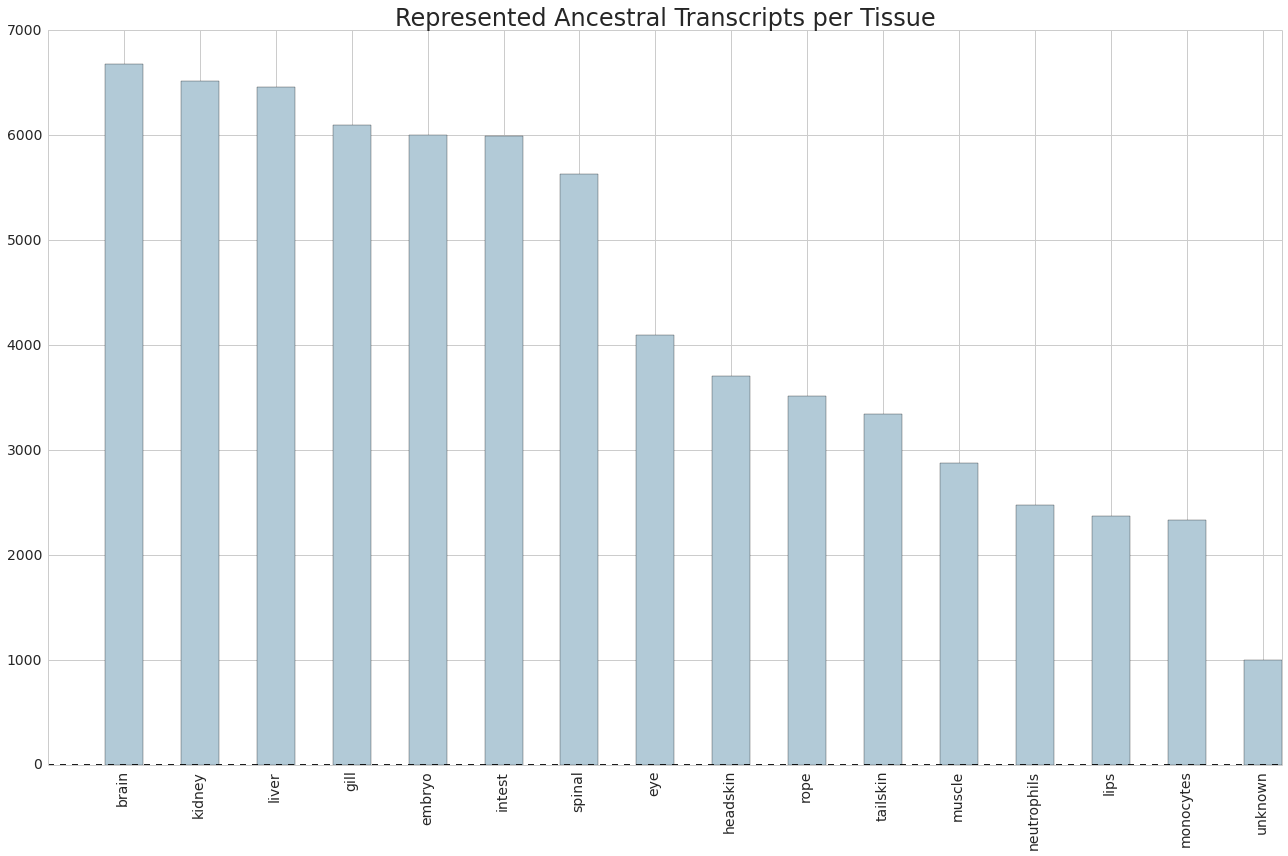

/w/lamprey/lamp3/2013-lamprey/notebooks/analyses/ancestral_transcripts_per_tissue.svg

In [119]:
with FigManager('ancestral_transcripts_per_tissue', figsize=norm_size, show=True) as (fig, ax):
    tissue_support_df[tissue_support_df.index.isin(ancestral_transcripts)].sum().order(ascending=False).plot(kind='bar', fontsize=14, figure=fig, ax=ax)
    ax.set_title('Represented Ancestral Transcripts per Tissue')
FileLink('ancestral_transcripts_per_tissue.svg')

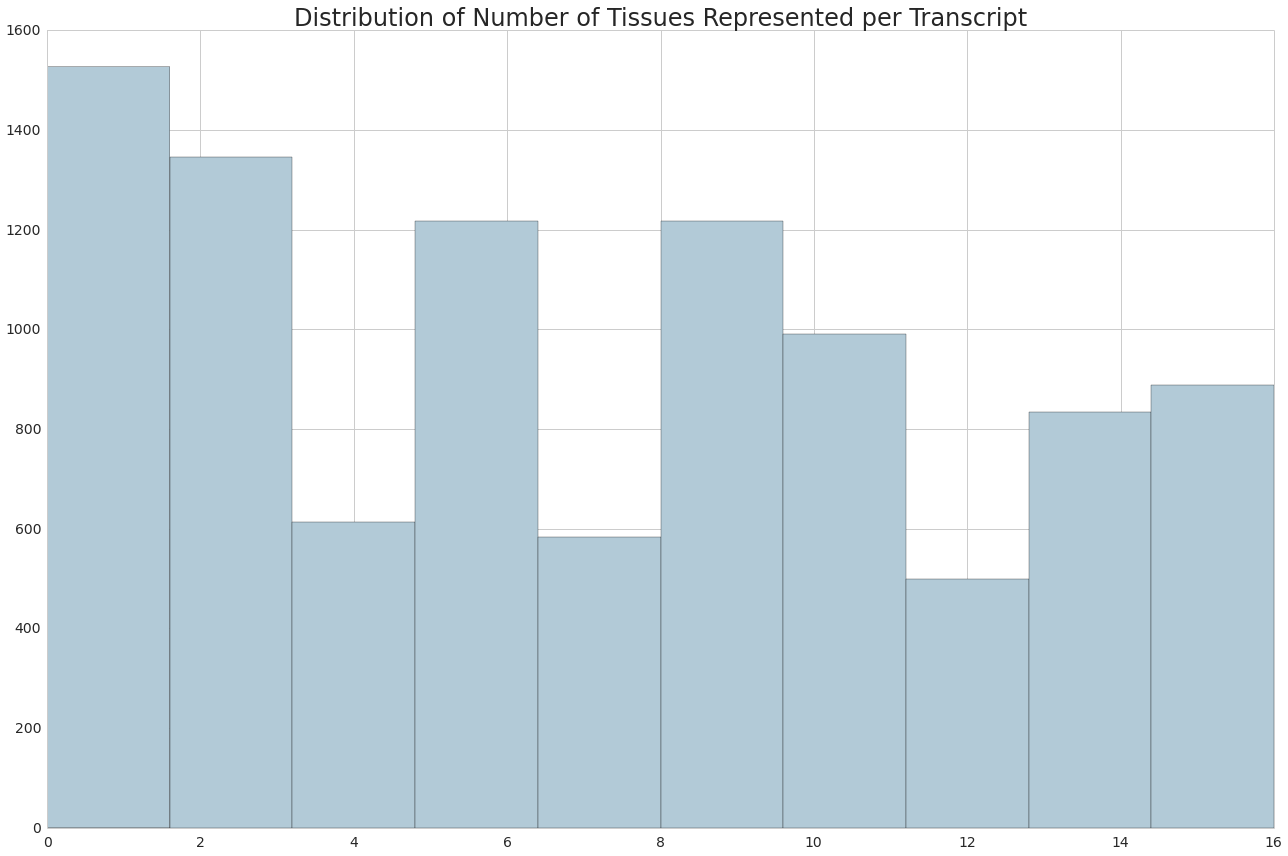

/w/lamprey/lamp3/2013-lamprey/notebooks/analyses/ancestral_tissue_hist.svg

In [121]:
with FigManager('ancestral_tissue_hist', figsize=norm_size, show=True) as (fig, ax):
    tissue_support_df[tissue_support_df.index.isin(ancestral_transcripts)].sum(axis=1).hist(figure=fig, ax=ax)
    ax.set_title('Distribution of Number of Tissues Represented per Transcript')
FileLink('ancestral_tissue_hist.svg')

### Sample-specific Genes

In [98]:
sample_specific_genes = gene_from_symbol(
                            list(set(gene_df[iso_support_df.sum(axis=1) == 1].values.flatten())),
                            mg=mg).groupby(level=0).apply(dedupe_gene_func)

querying 1-1000...done.
querying 1001-2000...done.
querying 2001-3000...done.
querying 3001-4000...done.
querying 4001-5000...done.
querying 5001-5295...done.
Finished.
4559 input query terms found dup hits:
	[(u'HIST1H4C', 7), (u'PTPN11B', 8), (u'PTPN11A', 7), (u'RNF17', 10), (u'ADAM10B', 8), (u'HRSP12', 10
34 input query terms found no hit:
	[u'CR759761.1', u'SI:CH211-233M11.2', u'CU658147.1', u'SI:CH211-183D5.1', u'SI:CH73-248E20.1', u'SI:
Pass "returnall=True" to return complete lists of duplicate or missing query terms.


In [99]:
sample_specific_genes['tag'] = sample_specific_genes.index
sample_specific_genes['alias_str'] = sample_specific_genes.alias.apply(lambda a: ','.join(a) if type(a) is list
                                                                   else np.nan)

In [100]:
with open('sample_specific_genes.fa', 'wb') as fp:
    sample_specific_genes.apply(transcript_write_func, axis=1, args=(gene_transcript_map, assem_db, fp))

In [101]:
sample_specific_genes.to_csv('sample_specific_genes.tsv', cols=['alias_str', 'name', 'go', '_id'], sep='\t', na_rep='*')

In [102]:
sample_specific_genes

_id  \
query                             
0610007P14RIK             58520   
0610009O20RIK             66839   
0610010F05RIK             71675   
0610011F06RIK             68347   
1110008L16RIK             66132   
1190002N15RIK             68861   
1700003M02RIK             69329   
1700028K03RIK             76421   
1700028P14RIK             67483   
1700040L02RIK             73287   
2310033P09RIK             67862   
2310035C23RIK            227446   
2410016O06RIK             71952   
2410131K14RIK             76792   
2610002M06RIK             67028   
2610507B11RIK             72503   
3110002H16RIK             76482   
4921506M07RIK             70846   
4930402H24RIK            228602   
4930427A07RIK            104732   
4930451C15RIK             74685   
4930529M08RIK             78774   
4932438A13RIK            229227   
5S_RRNA         ENSG00000277584   
9430016H08RIK             68115   
A230046K03RIK            319277   
A230050P20RIK            319278   
A330021E22RIK            207686   
A830018L16RIK            320492   
AADAT                     51166   
AAGAB                     79719   
AAK1                      22848   
AAK1A                    568999   
AAMP                         14   
AANAT                        15   
AANAT1                   393677   
AARSD1                    69684   
AASDHPPT                  60496   
AASS                      10157   
ABAT                         18   
ABCA1                        19   
ABCA1B                100136868   
ABCA3                        21   
ABCA3B                   564344   
ABCA5                     23461   
ABCB1A                    18671   
ABCB4                      5244   
ABCB6                     10058   
ABCB6A                   564067   
ABCB9                     23457   
ABCC5                     10057   
ABCC8                      6833   
ABCC9                     10060   
ABCD3                      5825   
ABCD3A                   406803   
ABCD4                      5826   
ABCF1                        23   
ABCF2                     10061   
ABCF2A                   336770   
ABCF3                     55324   
ABCG2                      9429   
ABCG2A                   735312   
ABCG2D                   735310   
ABHD1                     84696   
ABHD12                    26090   
ABHD13                    84945   
ABHD3                    171586   
ABHD8                     79575   
ABHD8A                   558563   
ABI1                      10006   
ABI1A                    393711   
ABI1B                    767738   
ABI2                      10152   
ABI2A                    767646   
ABLIM1                     3983   
ABLIM1B                  541550   
ABTB1                     80325   
AC068620.1                  NaN   
AC104534.3      ENSG00000268083   
AC126614.1                  NaN   
ACAA2                     10449   
ACACA                        31   
ACACB                        32   
ACAD8                     27034   
ACAD9                     28976   
ACADS                        35   
ACADSB                       36   
ACADVL                       37   
ACAP2                     23527   
ACAP3                    116983   
ACBD3                     64746   
ACBD5A                   553674   
ACBD6                     72482   
ACCS                      84680   
ACE                        1636   
ACE2                      59272   
ACE3                     217246   
ACER2                    340485   
ACLY                         47   
ACLYA                    436922   
...                         ...   
ZGC:172341               565385   
ZGC:173742               334557   
ZGC:173905            100126805   
ZGC:174356            100137120   
ZGC:174624            100151757   
ZGC:174689               795883   
ZGC:174708            100141335   
ZGC:175176               797890   
ZGC:194224               799070   
ZGC:194261               572372   
ZGC:194508            100004673   
ZGC:194841               565375   
ZGC

In [103]:
!python /w/khmer/sandbox/assemstats2.py 200 ../../work/lamp03.fasta

python: can't open file '/w/khmer/sandbox/assemstats2.py': [Errno 2] No such file or directory


In [104]:
!python /w/khmer/sandbox/assemstats2.py 200 sample_specific_genes.fa 

python: can't open file '/w/khmer/sandbox/assemstats2.py': [Errno 2] No such file or directory


### Sample-specific Genes Novel to Lamprey

In [ ]:
sample_specific_novel_genes = gene_from_symbol(filter_species(
                                    set(gene_df[(gene_df.petMar2_pep.isnull() & gene_df.petMar2_cdna.isnull() & \
                                        gene_df.petMar2_cds.isnull() & gene_df.petMar2_ncrna.isnull()) & \
                                        putative_df.novel & (iso_support_df.sum(axis=1) == 1)].values.flatten()
                                        ) - petMar2_ucsc, mg=mg),
                                    mg=mg).groupby(level=0).apply(dedupe_gene_func)

In [ ]:
sample_specific_novel_genes['tag'] = sample_specific_novel_genes.index
sample_specific_novel_genes['alias_str'] = sample_specific_novel_genes.alias.apply(lambda a: ','.join(a) if type(a) is list
                                                                   else np.nan)

In [ ]:
with open('sample_specific_novel_genes.fa', 'wb') as fp:
    sample_specific_novel_genes.apply(transcript_write_func, axis=1, args=(gene_transcript_map, assem_db, fp))

In [ ]:
sample_specific_novel_genes.to_csv('sample_specific_novel_genes.tsv', cols=['alias_str', 'name', 'go', '_id'], sep='\t', na_rep='*')

In [ ]:
sample_specific_novel_genes

### Gene Workspace

We can use Pandas' built-in string search functions to extract genes using regular expressions.

In [ ]:
petMar2_novel_genes[petMar2_novel_genes.name.str.contains(r'zinc finger', na=False, case=False)]

## Transcript Sample-number Distribution

In [ ]:
with sns.color_palette("Set3"), FigManager('transcript_sample_dist_support', figsize=norm_size, show=True) as (fig, ax):
    tmp = pd.DataFrame({'Transcripts': iso_support_df.sum(axis=1), 
                  'Putative': putative_df.homology,
                  'Genome': blast_df.petMar2,
                  'Mouse': blast_df.musMus_pep,
                  'Zebrafish': blast_df.danRer_pep,
                  }).groupby('Transcripts').agg({'Transcripts': len, 
                                                 'Putative': sum,
                                                 'Genome': sum,
                                                 'Mouse': sum,
                                                 'Zebrafish': sum})
    tmp.plot(figure=fig, ax=ax, lw=3, fontsize=16, legend=False)
    tmp.to_html('transcript_sample_dist_support.html')
    #print tmp
    ax.set_title('Homology support in Distribution of Transcript Sample-number Representation')
    ax.legend(fontsize=16)

In [ ]:
with FigManager('transcript_sample_dist_support', figsize=norm_size, show=True) as (fig, ax):
    iso_support_df.sum(axis=1).hist(bins=len(iso_support_df.columns),
                                      figure=fig, ax=ax)
    pd.DataFrame({'r': iso_support_df.sum(axis=1), 
                  'Homologies': putative_df.homology}).groupby('r').sum().plot(figure=fig,
                                                                                ax=ax, legend=False)
    ax.legend(fontsize=14)
    ax.set_title('Distribution of Transcript Sample-number and Homology Support')
FileLink('transcript_sample_dist_support.pdf')

In [ ]:
iso_rsem_df.iloc[20:30,4:10].to_html('sample_vector_example.html')

## Between-Sample Similarity

### Hamming Distance

Measures the number of disagreeing dimensions in the two vectors, normalized by the number of dimensions.

In [ ]:
plot_dendro(iso_support_df, 
            title_text='Between-Sample Hamming Distance, Centroid',
            cmap=plt.cm.RdBu_r,
            fn='sample_dendro_hamming_centroid',
            figsize=(24,18))
FileLink('sample_dendro_hamming_centroid.svg')

In [ ]:
plot_dendro(iso_support_df,
            title_text='Between-Sample Hamming Distance, Ward',
            method='ward',
            cmap=plt.cm.RdBu_r,
            fn='sample_dendro_hamming_ward')
FileLink('sample_dendro_hamming_ward.svg')

In [ ]:
plot_dendro(iso_support_df[putative_df.additions],
            title_text='Between-Sample Hamming Distance, Ward (putative new)',
            distance='hamming',
            method='ward',
            cmap=plt.cm.RdBu_r,
            fn='sample_dendro_hamming_ward_putnew')
FileLink('sample_dendro_hamming_ward_putnew.svg')

### Correlation Distance

Statistcal independence between samples. This takes into account the transcript abundances.

In [ ]:
plot_dendro(iso_rsem_df,
            distance='correlation',
            title_text='Between-Sample Correlation Distance, Centroid',
            cmap=plt.cm.RdBu_r,
            fn='sample_dendro_correlation_centroid')
FileLink('sample_dendro_correlation_centroid.svg')

In [ ]:
plot_dendro(iso_rsem_df,
            distance='correlation',
            method='ward',
            title_text='Between-Sample Correlation Distance, Ward',
            cmap=plt.cm.RdBu_r,
            fn='sample_dendro_correlation_ward')
FileLink('sample_dendro_correlation_ward.svg')

## Between-Tissue Similarity

In [ ]:
plot_dendro(tissue_support_df, 
            title_text='Between-Tissue Hamming Distance, Centroid',
            cmap=plt.cm.RdBu_r,
            fn='tissue_dendro_hamming_centroid',
            figsize=(24,18),
            labelsize=20)
FileLink('tissue_dendro_hamming_centroid.svg')

In [ ]:
plot_dendro(tissue_support_df,
            title_text='Between-Tissue Hamming Distance, Ward',
            method='ward',
            cmap=plt.cm.RdBu_r,
            fn='tissue_dendro_hamming_ward',
            labelsize=20)
FileLink('tissue_dendro_hamming_ward.svg')

In [ ]:
plot_dendro(tissue_tr_df, 
            title_text='Between-Tissue Transcript-Number Correlation Distance, Centroid',
            cmap=plt.cm.RdBu_r,
            fn='tissue_dendro_tr_correlation_centroid',
            figsize=(24,18),
            labelsize=20)
FileLink('tissue_dendro_tr_correlation_centroid.svg')

In [ ]:
plot_dendro(tissue_exp_df, 
            title_text='Between-Tissue Median-Expression Correlation Distance, Centroid',
            cmap=plt.cm.RdBu_r,
            fn='tissue_dendro_exp_correlation_centroid',
            figsize=(24,18),
            labelsize=20)
FileLink('tissue_dendro_exp_correlation_centroid.svg')

In [ ]:
plot_dendro(iso_support_df[labels_df[(labels_df.tissue == 'liver')].newname],
            distance='hamming',
            title_text='Liver Between-Sample Hamming Distance, Centroid',
            cmap=plt.cm.RdBu_r,
            fn='liver_dendro_hamming_centroid',
            labelsize=12)
FileLink('liver_dendro_hamming_centroid.svg')

In [ ]:
plot_dendro(iso_rsem_df[labels_df[labels_df.tissue == 'liver'].newname],
            distance='correlation',
            title_text='Liver Between-Sample Correlation Distance, Centroid',
            cmap=plt.cm.RdBu_r,
            fn='liver_dendro_correlation_centroid',
            labelsize=12)
FileLink('liver_dendro_correlation_centroid.svg')

In [ ]:
plot_dendro(iso_support_df[labels_df[labels_df.tissue == 'kidney'].newname],
            distance='hamming',
            title_text='Kidney Between-Sample Hamming Distance, Centroid',
            cmap=plt.cm.RdBu_r,
            fn='kidney_dendro_hamming_centroid',
            labelsize=12)
FileLink('kidney_dendro_hamming_centroid.svg')

## PCA

Work in progress...

In [51]:
iso_PCA = PCA()
iso_PCA.fit(iso_rsem_df.transpose())

PCA(copy=True, n_components=None, whiten=False)

In [52]:
iso_rsem_pca_df = pd.DataFrame(iso_PCA.transform(iso_rsem_df.transpose()).transpose(), 
                               columns=list(iso_support_df.columns))

leaving context of <matplotlib.figure.Figure object at 0x49817d50>
saving figure <matplotlib.figure.Figure object at 0x9b58550>
showing figure <matplotlib.figure.Figure object at 0x9b58550>


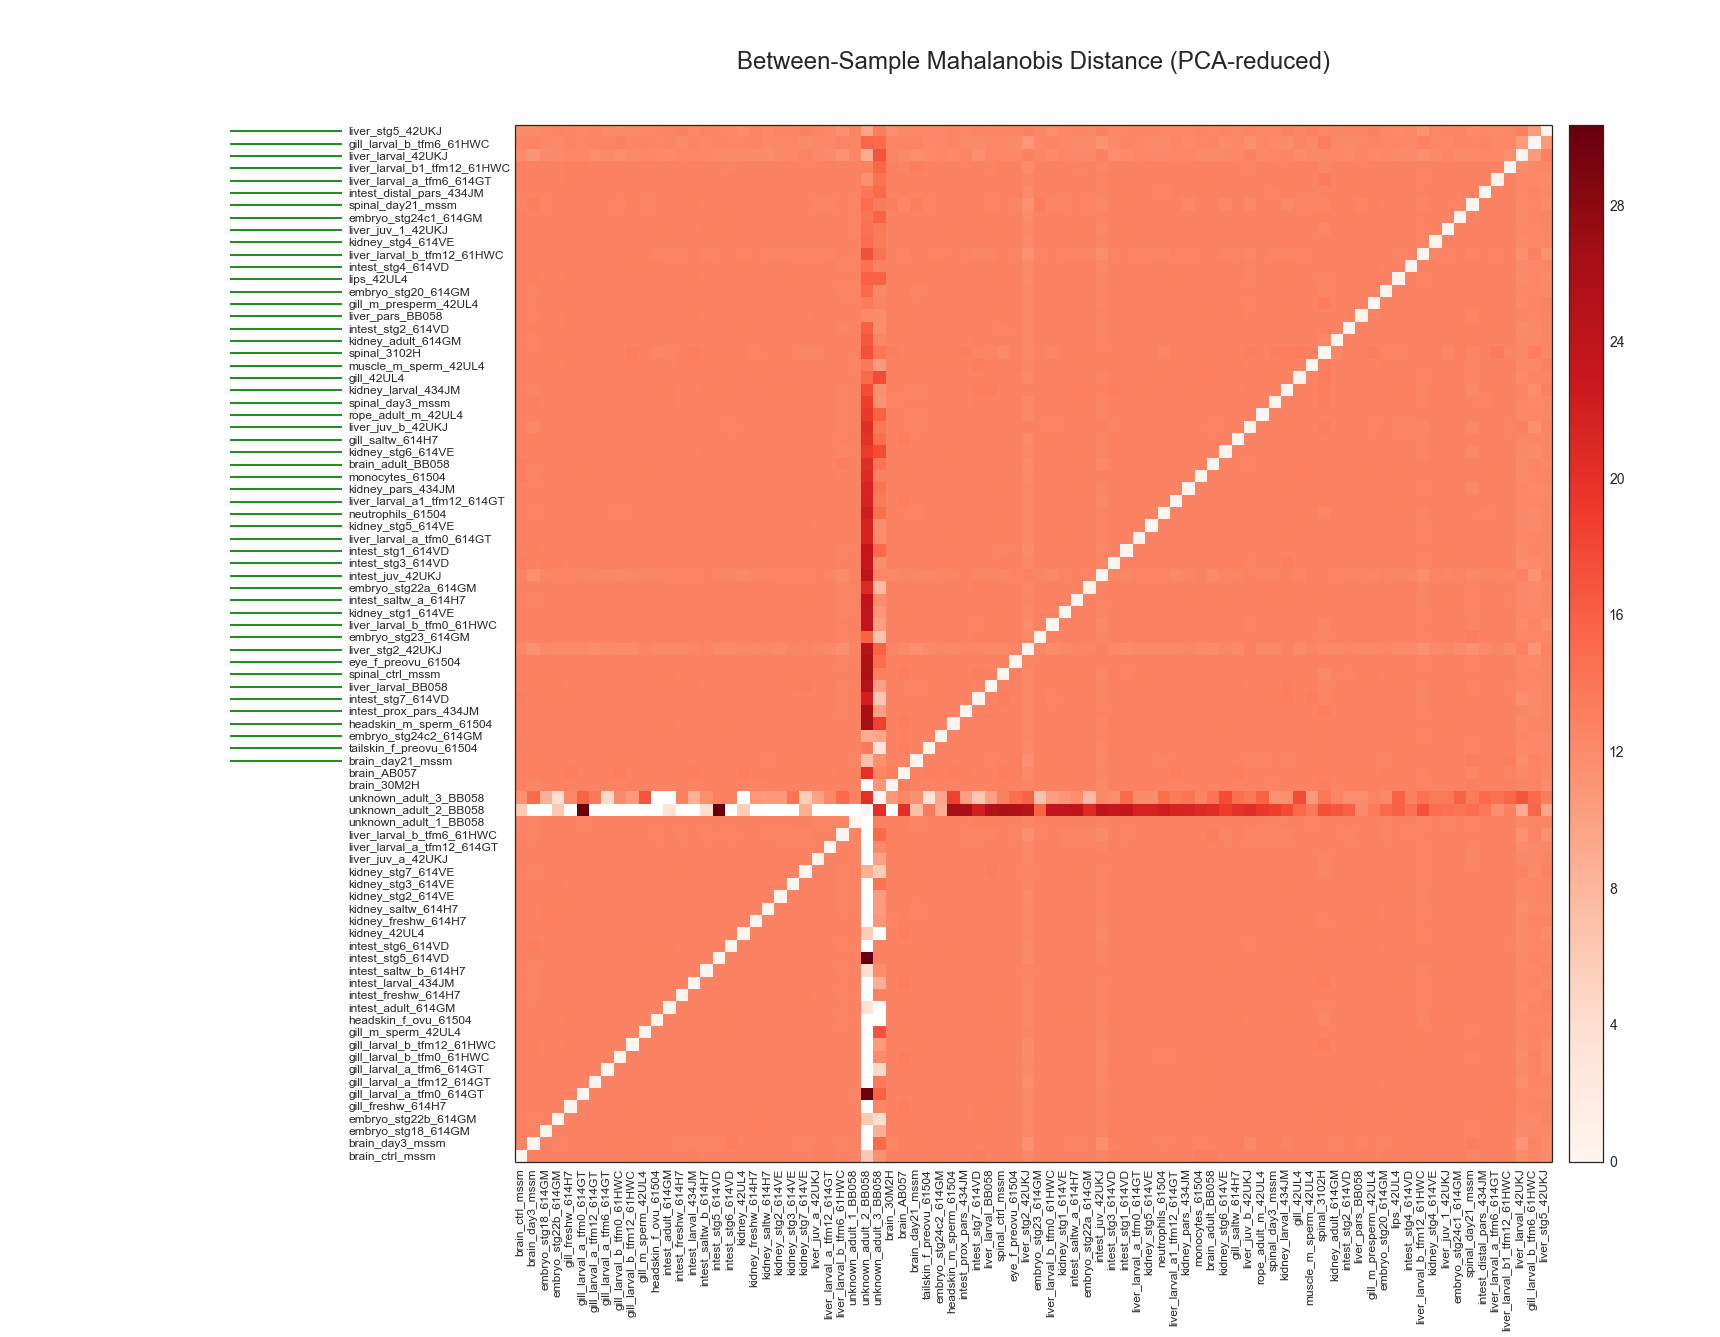

closing figure <matplotlib.figure.Figure object at 0x9b58550>
returning context to <matplotlib.figure.Figure object at 0x32488190>


In [53]:
plot_dendro(iso_rsem_pca_df,
            distance='mahalanobis',
            title_text='Between-Sample Mahalanobis Distance (PCA-reduced)', 
            fn='sample_dendro_mahalanobis_pca')

leaving context of <matplotlib.figure.Figure object at 0x32488190>
saving figure <matplotlib.figure.Figure object at 0x81c52dd0>
showing figure <matplotlib.figure.Figure object at 0x81c52dd0>


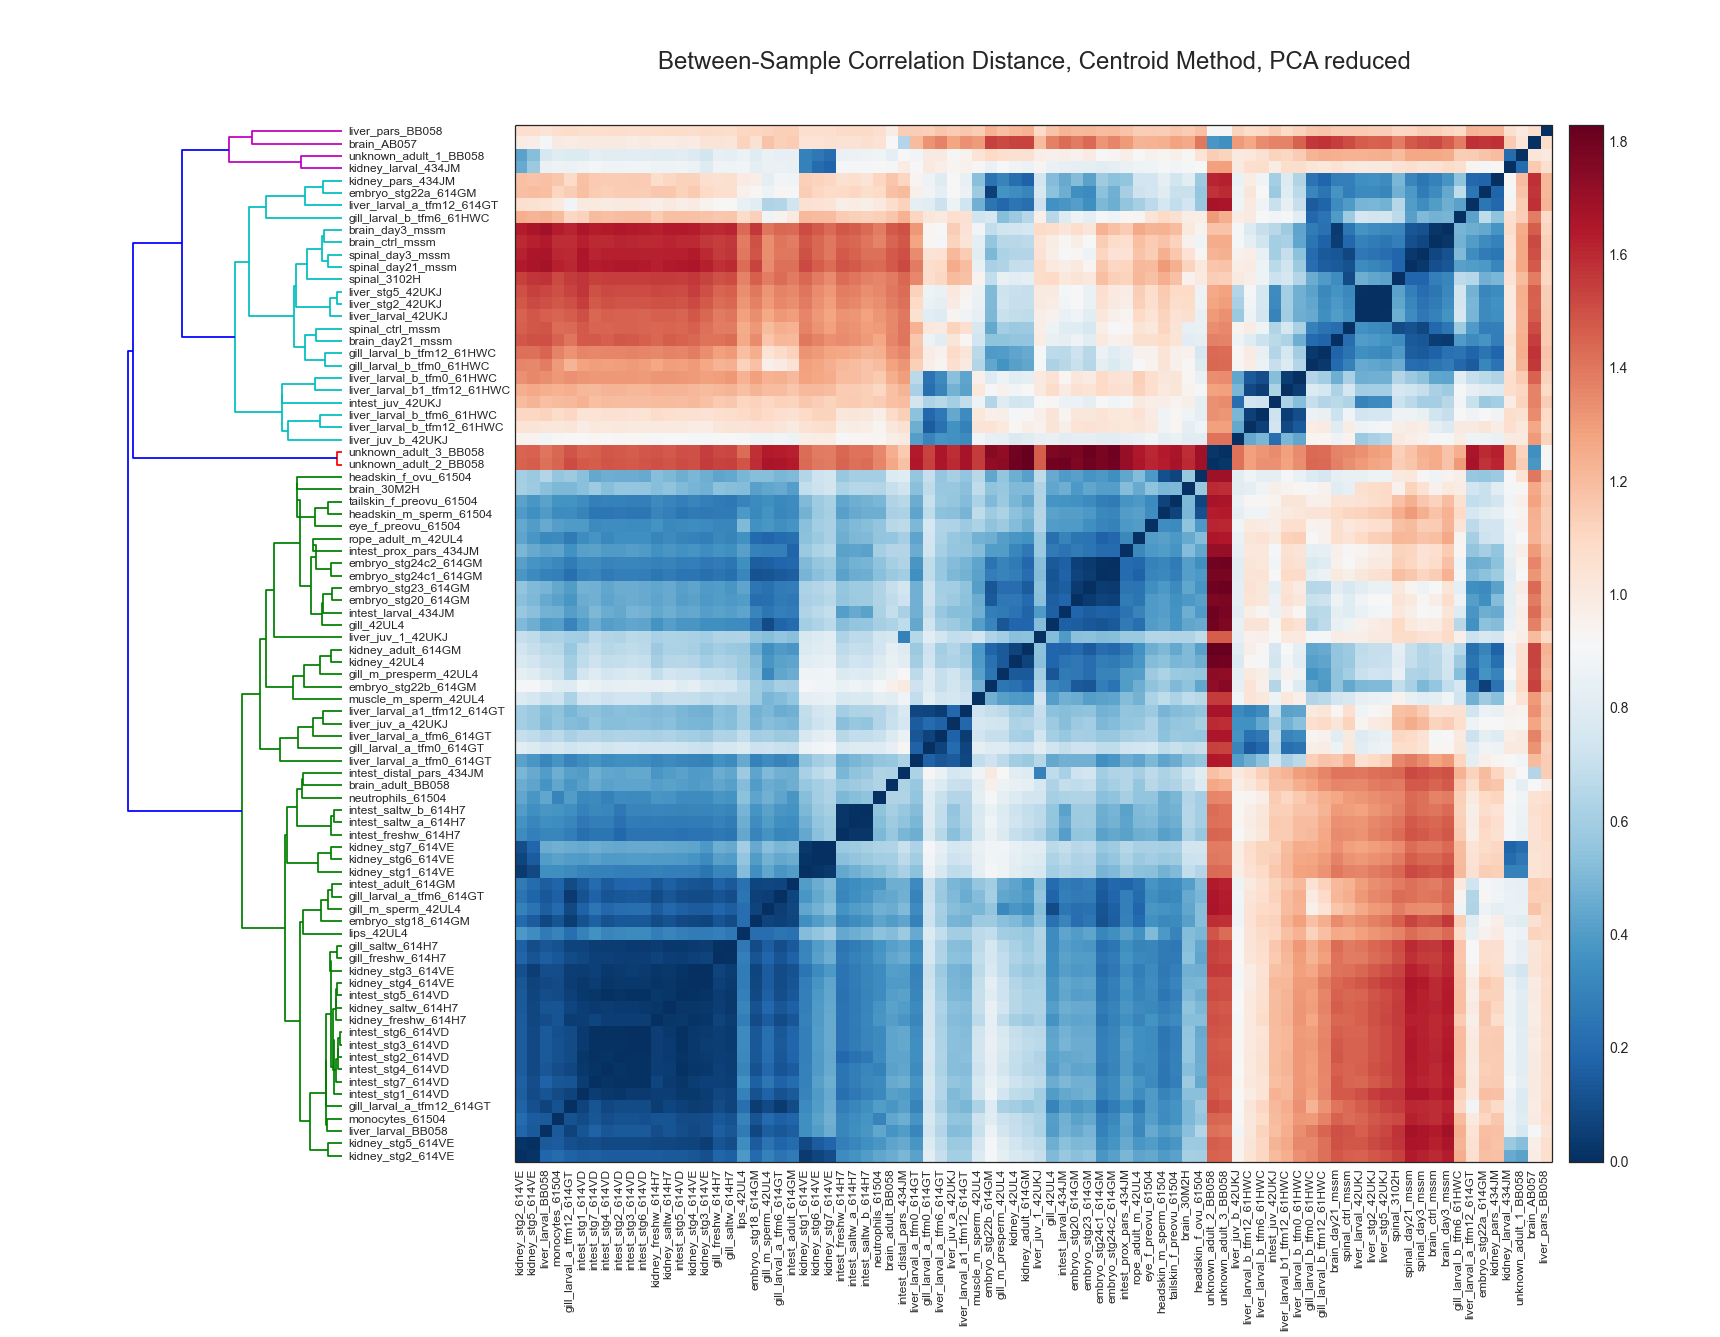

closing figure <matplotlib.figure.Figure object at 0x81c52dd0>
returning context to <matplotlib.figure.Figure object at 0x6b2604d0>


In [54]:
plot_dendro(iso_rsem_pca_df,
            distance='correlation',
            method='centroid',
            title_text='Between-Sample Correlation Distance, Centroid Method, PCA reduced',
            cmap=plt.cm.RdBu_r,
            fn='sample_dendro_correlation_pca')

leaving context of <matplotlib.figure.Figure object at 0x6b2604d0>
saving figure <matplotlib.figure.Figure object at 0x81c42050>
showing figure <matplotlib.figure.Figure object at 0x81c42050>


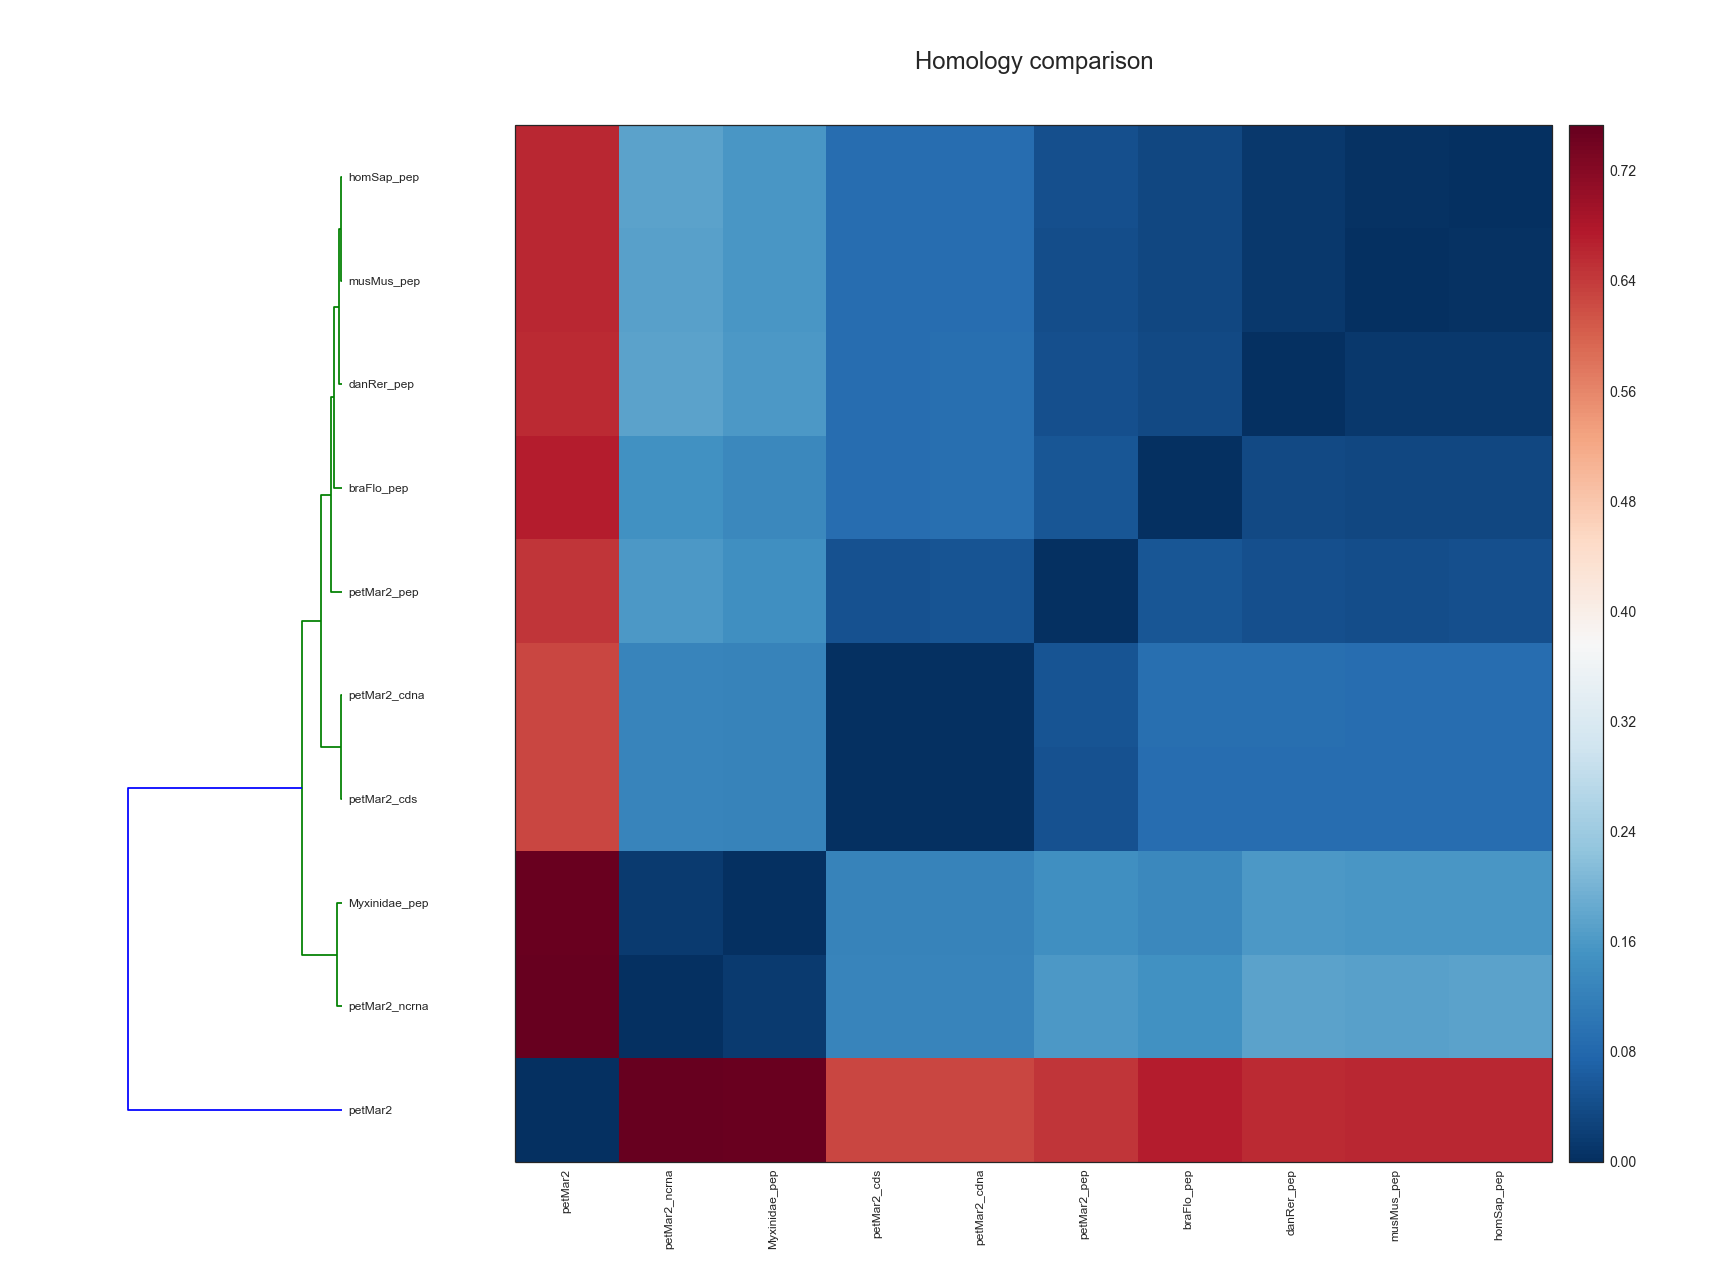

closing figure <matplotlib.figure.Figure object at 0x81c42050>
returning context to <matplotlib.figure.Figure object at 0x1096d5d0>


In [55]:
plot_dendro(blast_df,
            distance='hamming',
            title_text='Homology comparison',
            cmap=plt.cm.RdBu_r,
            fn='homology_dendro_hamming_centroid')

leaving context of <matplotlib.figure.Figure object at 0x1096d5d0>
saving figure <matplotlib.figure.Figure object at 0x32489590>
showing figure <matplotlib.figure.Figure object at 0x32489590>


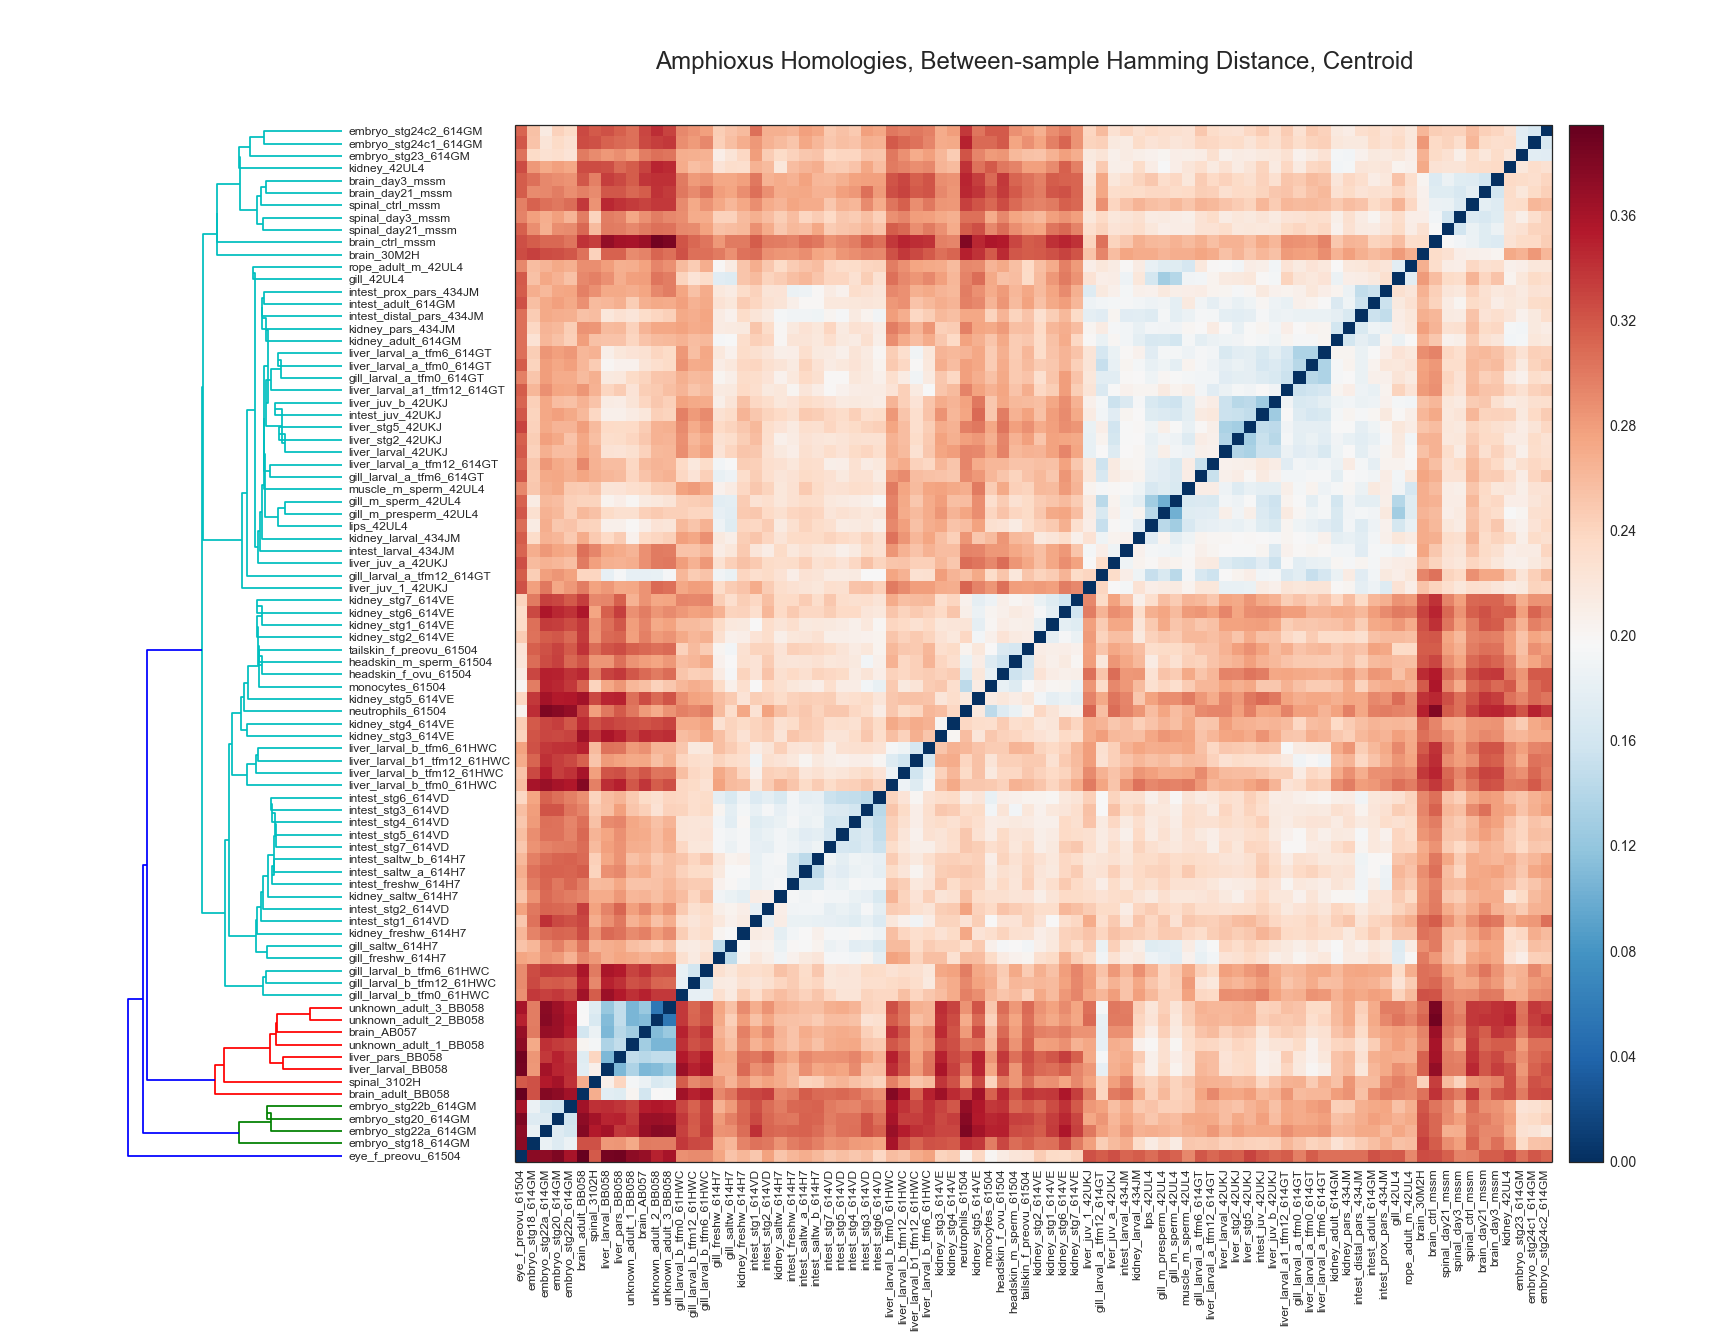

closing figure <matplotlib.figure.Figure object at 0x32489590>
returning context to <matplotlib.figure.Figure object at 0x5f196e50>


/w/lamprey/lamp3/2013-lamprey/notebooks/analyses/amphioxus_dendro_hamming_centroid.svg

In [56]:
plot_dendro(iso_support_df[blast_df.braFlo_pep & ((blast_df.musMus_pep | blast_df.danRer_pep) == False)],
            title_text='Amphioxus Homologies, Between-sample Hamming Distance, Centroid',
            cmap=plt.cm.RdBu_r,
            fn='amphioxus_dendro_hamming_centroid')
FileLink('amphioxus_dendro_hamming_centroid.svg')

leaving context of <matplotlib.figure.Figure object at 0x5f196e50>
saving figure <matplotlib.figure.Figure object at 0x10961e90>
showing figure <matplotlib.figure.Figure object at 0x10961e90>


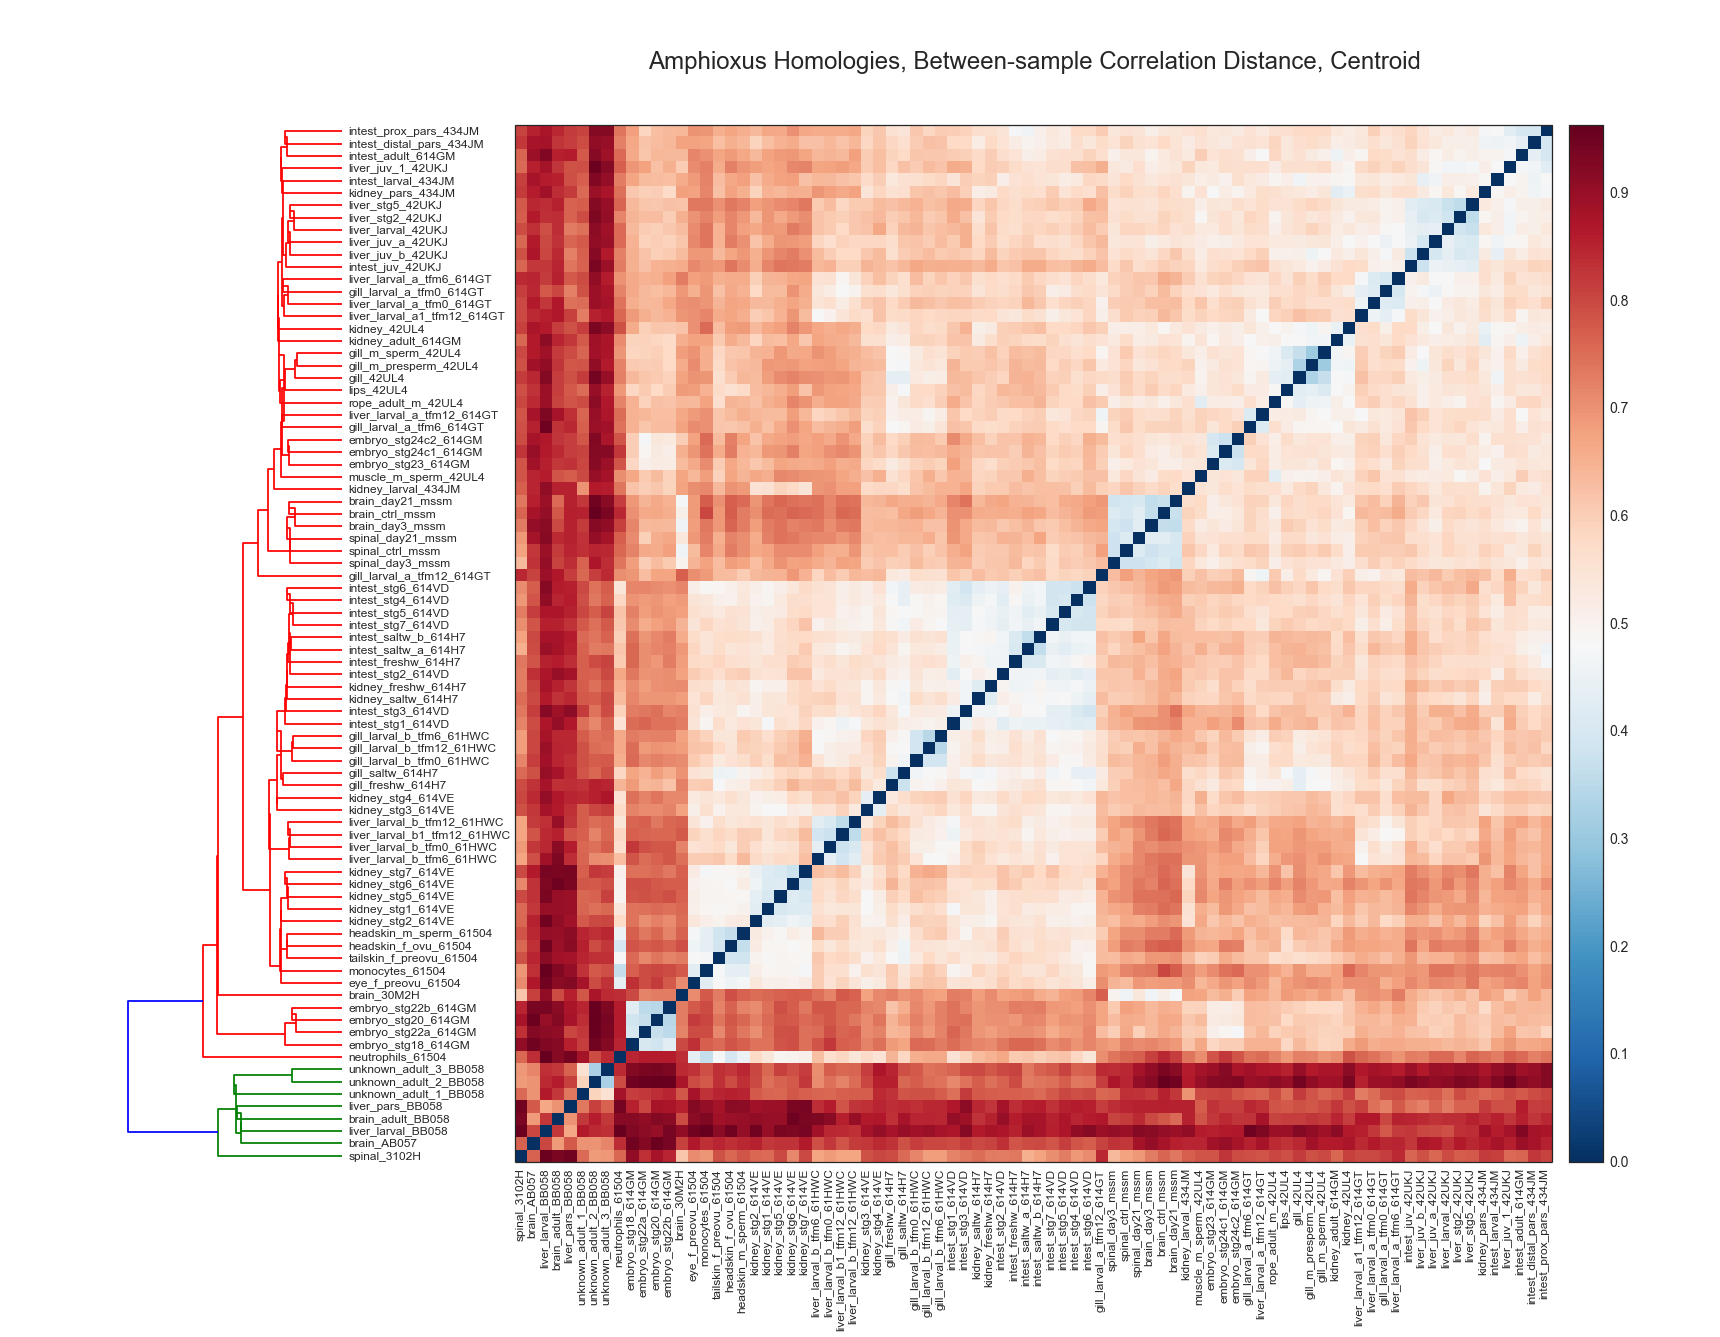

closing figure <matplotlib.figure.Figure object at 0x10961e90>
returning context to <matplotlib.figure.Figure object at 0x15e59290>


/w/lamprey/lamp3/2013-lamprey/notebooks/analyses/amphioxus_dendro_correlation_centroid.svg

In [57]:
plot_dendro(iso_support_df[blast_df.braFlo_pep & ((blast_df.musMus_pep | blast_df.danRer_pep) == False)],
            title_text='Amphioxus Homologies, Between-sample Correlation Distance, Centroid',
            distance='correlation',
            cmap=plt.cm.RdBu_r,
            fn='amphioxus_dendro_correlation_centroid')
FileLink('amphioxus_dendro_correlation_centroid.svg')

leaving context of <matplotlib.figure.Figure object at 0x15e59290>
saving figure <matplotlib.figure.Figure object at 0x5f18b110>
showing figure <matplotlib.figure.Figure object at 0x5f18b110>


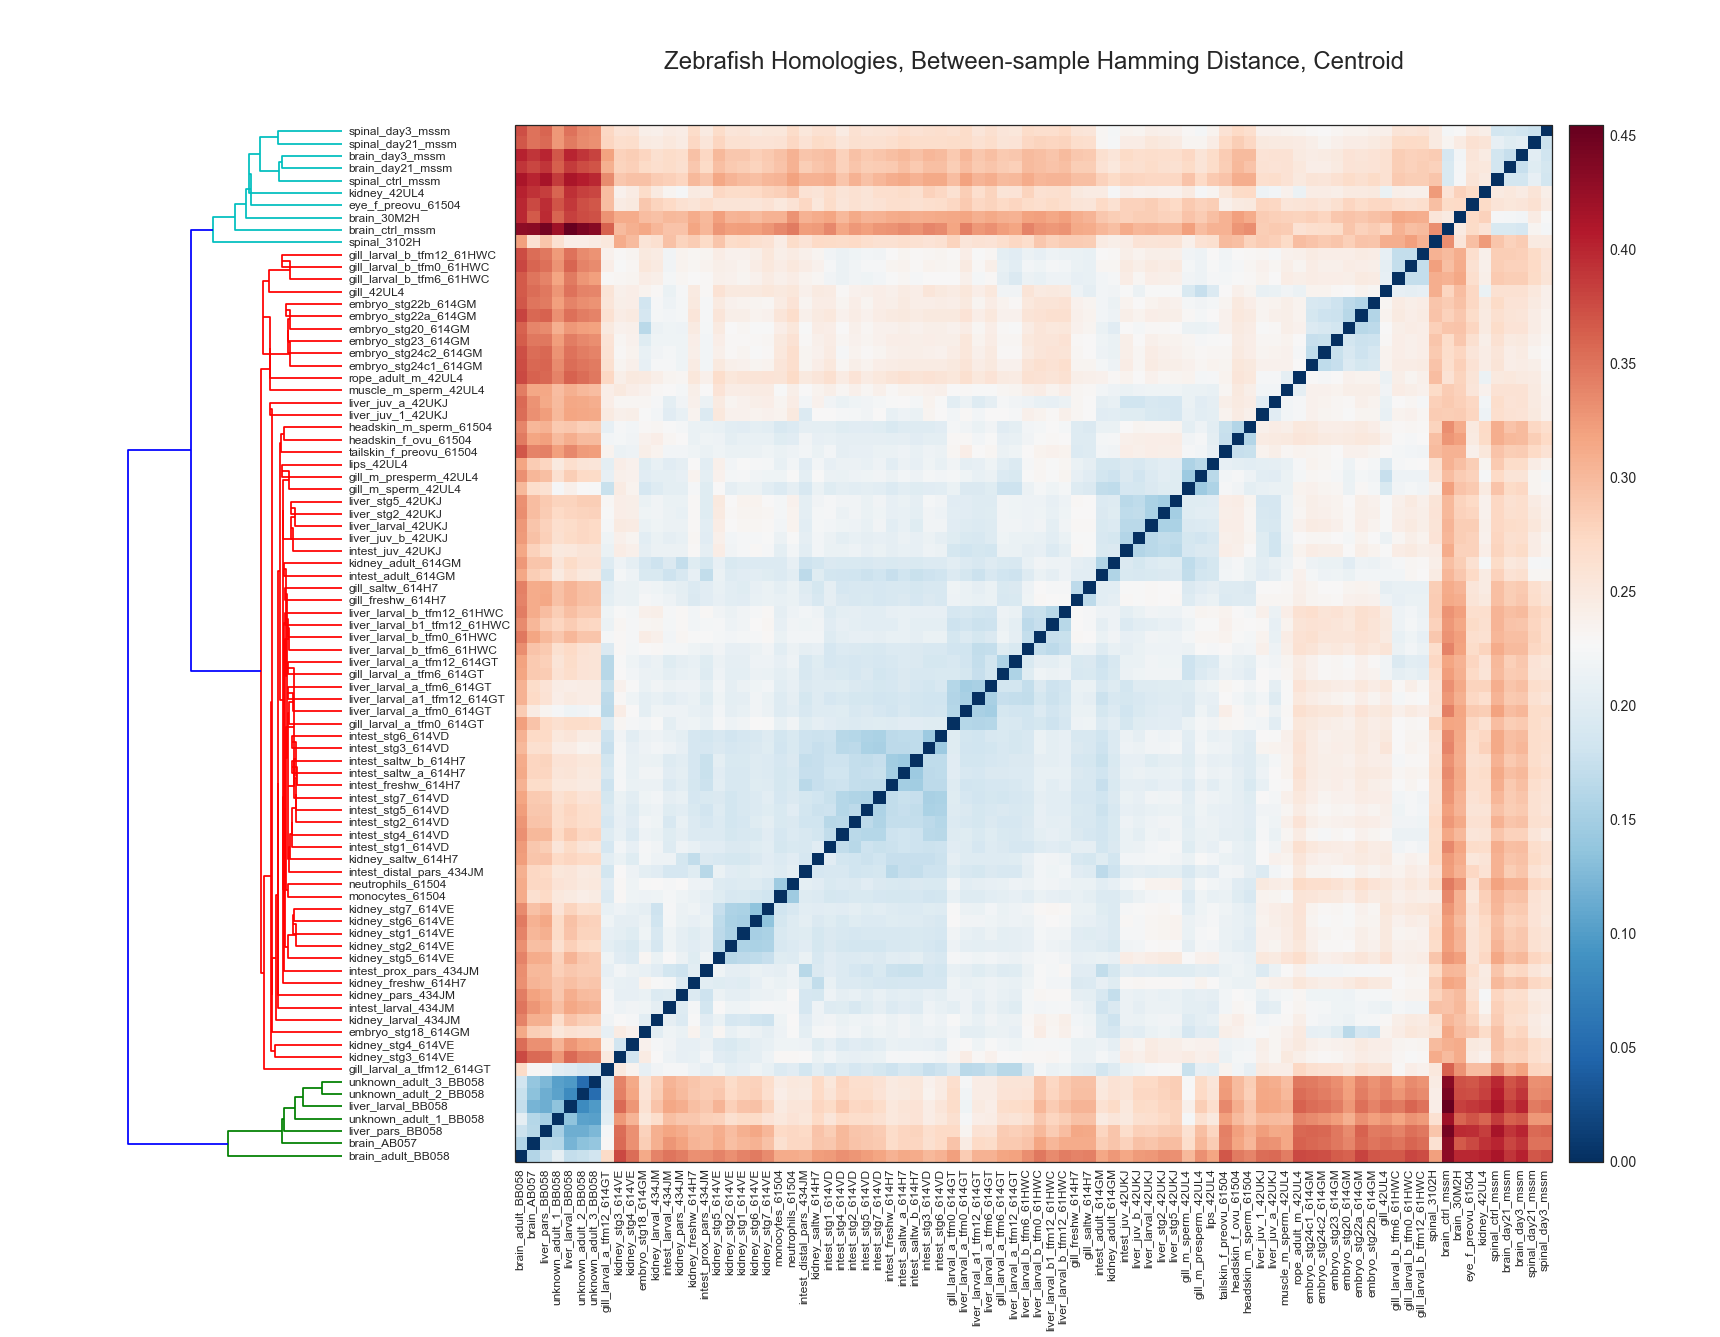

closing figure <matplotlib.figure.Figure object at 0x5f18b110>
returning context to <matplotlib.figure.Figure object at 0x6cd07f10>


/w/lamprey/lamp3/2013-lamprey/notebooks/analyses/zebrafish_dendro_hamming_centroid.svg

In [58]:
plot_dendro(iso_support_df[blast_df.danRer_pep & ((blast_df.braFlo_pep) == False)],
            title_text='Zebrafish Homologies, Between-sample Hamming Distance, Centroid',
            cmap=plt.cm.RdBu_r,
            fn='zebrafish_dendro_hamming_centroid')
FileLink('zebrafish_dendro_hamming_centroid.svg')

leaving context of <matplotlib.figure.Figure object at 0x6cd07f10>
saving figure <matplotlib.figure.Figure object at 0x292398d0>
showing figure <matplotlib.figure.Figure object at 0x292398d0>


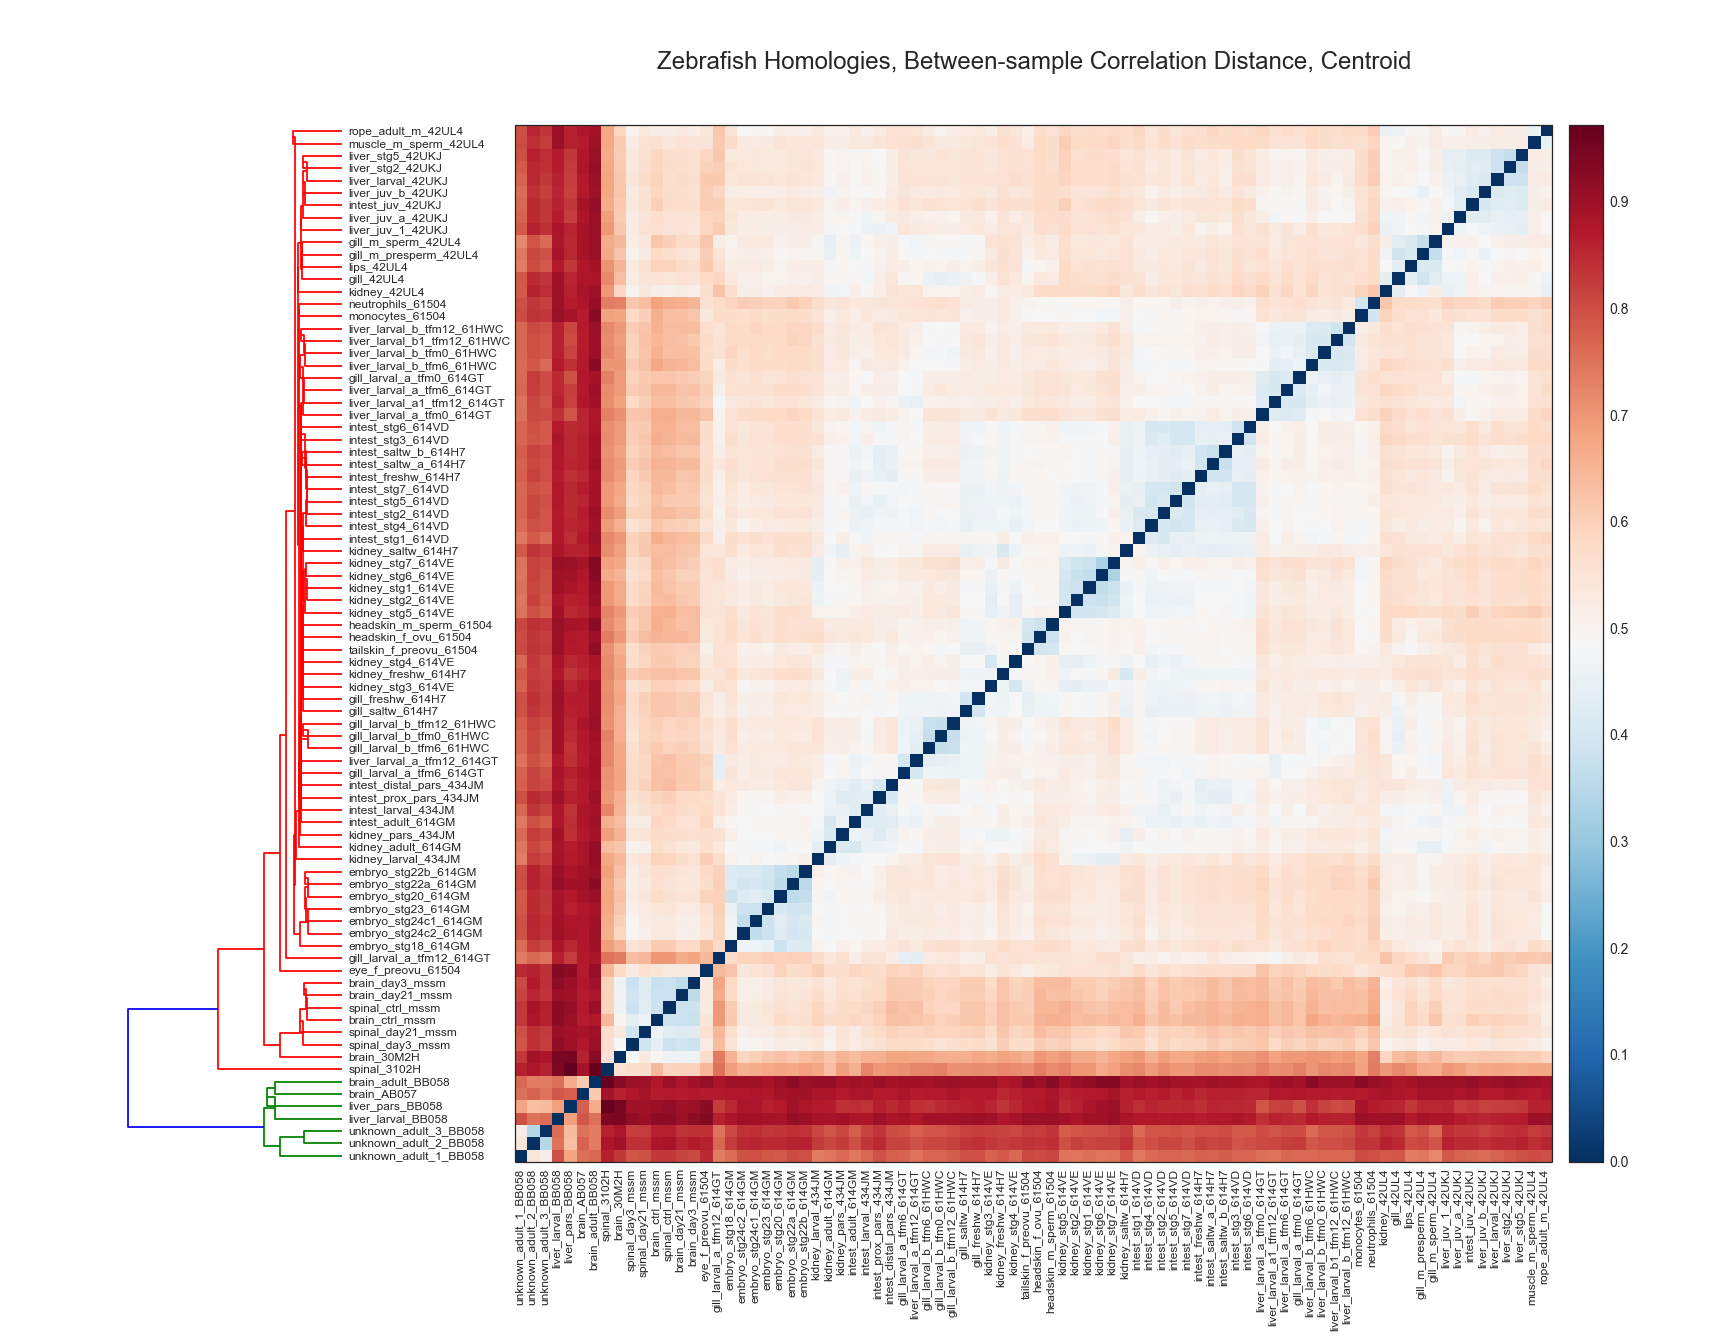

closing figure <matplotlib.figure.Figure object at 0x292398d0>
returning context to <matplotlib.figure.Figure object at 0x1095ffd0>


/w/lamprey/lamp3/2013-lamprey/notebooks/analyses/zebrafish_dendro_correlation_centroid.svg

In [59]:
plot_dendro(iso_support_df[blast_df.danRer_pep & ((blast_df.braFlo_pep) == False)],
            distance='correlation',
            title_text='Zebrafish Homologies, Between-sample Correlation Distance, Centroid',
            cmap=plt.cm.RdBu_r,
            fn='zebrafish_dendro_correlation_centroid')
FileLink('zebrafish_dendro_correlation_centroid.svg')

## Miscellany

In [555]:
blast_panel.minor_xs('evalue').median()

petMar2          4.000000e-158
petMar2_pep       8.000000e-64
petMar2_cds       0.000000e+00
petMar2_ncrna     7.000000e-34
petMar2_cdna      0.000000e+00
musMus_pep        7.000000e-47
danRer_pep        2.000000e-45
homSap_pep        4.000000e-47
braFlo_pep        2.000000e-36
Myxinidae_pep     1.000000e-16
dtype: float64

In [60]:
pd.DataFrame({'transcripts': iso_support_df[iso_support_df.sum(axis=1) == 1].sum(),
         'hits': iso_support_df.loc[(xgenome_ix | xlamp0_ix | petMar2_cdna_ix) & (iso_support_df.sum(axis=1) == 1),:].sum(),
         }).plot(kind='bar')

NameError: name 'xgenome_ix' is not defined

In [ ]:
squareform(pdist(pd.DataFrame({'a': iso_rsem_df.transpose().iloc[0], 'b': iso_rsem_df.transpose().iloc[0]}), 'correlation'))

In [ ]:
pd.DataFrame({'a': iso_rsem_df.transpose().iloc[0], 'b': iso_rsem_df.transpose().iloc[0]}).transpose().max(axis=1)

In [ ]:
blast_core_view = blast_df.ix[:,['xgenome', 'petMar2_cdna', 'xlamp0', 'xzebrafish', 'xmouse', 'xamph']]

In [ ]:
with FigManager(show=True) as (fig, ax):
    blast_core_view[blast_core_view.sum(axis=1) == 1].sum().plot(kind='bar', figure=fig, ax=ax)

In [ ]:
plot_dendro(blast_core_view,
            distance='hamming',
            title_text='Homology comparison, core databases',
            cmap=plt.cm.RdBu_r,
            fn='homology_core_dendro_hamming_centroid.svg')